# Imports

In [161]:
# Data
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import optuna
# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import xgboost as xgb
import gpboost as gpb
# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Misc
from IPython.display import HTML
from tqdm import tqdm
from typing import Any, Tuple, Optional, List, Union, Dict # type tips
import warnings
from itertools import combinations
import logging
import os
import pickle

# Data

Note that data has been limited to days 5-81 (inclusive) out of the total 84 days.

- Early days involved learning how to do tasks and getting used to the interface/survey questions (i.e. calibrating responses). 
- Final days sometimes showed odd outliers that perhaps indicate that some subjects stopped responding accurately as they got very close to completion

In [3]:
# Specify path
path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/'

In [30]:
# Raw Data
df_raw = pd.read_csv(path + 'df_raw.csv')

# load undetrended data
df_undetrended = pd.read_csv(path + 'df_cleaned_no_outliers.csv')

# Processed (detrended) data
df = pd.read_csv(path + 'df_cleaned_no_outliers_detrended.csv')

# MLM results
mlm1_4 = pd.read_csv(path + 'mlm_1-4_feature.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_13861/1765045058.py:2: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(path + 'df_raw.csv')


## Data Subsets

### Passive Features

In [34]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

### Self Report Features

In [35]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

# remove occupation features
sr_cols = [col for col in sr_cols if 'occupation' not in col]

# remove cols that are explicitly gaps
sr_cols = [col for col in sr_cols if '_gap' not in col]

### Task Data

In [36]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

# getting kernel error - remove task_hanoi_solved from task_cols
task_cols = [col for col in task_cols if 'task_hanoi_solved' not in col]

### Affect Features


In [37]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

# Helper Functions

In [7]:
def create_train_test_split(data: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on target variable
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - target: Target variable to determine last valid day
        target: Name of target variable column
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on target variable
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data[target].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [ ]:
def find_top_features(df, n_predictors=1, data_modality=None, min_observations=0, 
                      sort_by='abs_z_score', top_n=1, verbose=True):
    """
    Finds the top features from a results dataframe based on specified criteria.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing model results
    n_predictors : int, default=1
        Number of predictors in the model to filter for
    data_modality : str or list, default=None
        Data modality to filter for (e.g., 'passive', 'sr'). If None, all modalities included.
    min_observations : int, default=0
        Minimum number of observations required
    sort_by : str, default='abs_z_score'
        Metric to sort by: 'abs_z_score', 'z_score', 'p_value', 'bic', 'aic', 'mean_error', etc.
    top_n : int, default=1
        Number of top features to return
    verbose : bool, default=True
        Whether to print results
        
    Returns
    -------
    pandas.DataFrame
        Dataframe containing the top_n features based on specified criteria
    """
    # Create a copy of the dataframe to avoid modifying the original
    results = df.copy()
    
    # Apply filtering conditions
    if n_predictors is not None:
        results = results[results['n_predictors'] == n_predictors]
        
    if data_modality is not None:
        if isinstance(data_modality, list):
            results = results[results['data_modality'].isin(data_modality)]
        else:
            results = results[results['data_modality'] == data_modality]
    
    if min_observations > 0:
        results = results[results['n_observations'] > min_observations]
    
    # Define metrics where smaller values are better
    smaller_is_better = ['bic', 'aic', 'mean_error', 'rmse', 'mae', 'p_value']
    
    # Create absolute z-score column if sorting by it
    if sort_by == 'abs_z_score':
        results['abs_z'] = results['z_score'].abs()
        sort_col = 'abs_z'
        use_smallest = False
    else:
        sort_col = sort_by
        use_smallest = sort_col.lower() in smaller_is_better
    
    # Check if sort column exists
    if sort_col not in results.columns:
        raise ValueError(f"Column '{sort_col}' not found in dataframe")
    
    # Get top features - using smallest for metrics where lower is better
    if use_smallest:
        top_features = results.nsmallest(top_n, sort_col)
    else:
        top_features = results.nlargest(top_n, sort_col)
    
    # Print results if verbose
    if verbose and len(top_features) > 0:
        modality_str = data_modality if data_modality else "all modalities"
        print(f"Top {top_n} features for {n_predictors}-predictor models with {modality_str}:")
        print(f"Minimum observations: {min_observations}, Sorted by: {sort_by}")
        print("\nResults:")
        
        for i, row in top_features.iterrows():
            print(f"\nRank {top_features.index.get_loc(i) + 1}:")
            
            # Print feature names based on n_predictors
            for j in range(1, n_predictors + 1):
                feature_col = f'feature_{j}'
                if feature_col in row:
                    print(f"Feature {j}: {row[feature_col]}")
            
            # Print the sorting metric
            if sort_col in row:
                if sort_col == 'abs_z':
                    print(f"abs_z_score: {row[sort_col]:.3f}")
                    print(f"z_score: {row['z_score']:.3f}")
                else:
                    print(f"{sort_col}: {row[sort_col]:.4f}")
            
            # Print additional key metrics
            if 'n_observations' in row:
                print(f"Number of observations: {row['n_observations']}")
    
    return top_features

In [10]:
def plot_model_diagnostics(actual_vals: np.ndarray, predicted_vals: np.ndarray, test_data_clean: pd.DataFrame) -> None:
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    actual_vals : array-like
        The actual target values from the test set
    predicted_vals : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = actual_vals - predicted_vals
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=actual_vals, y=predicted_vals, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([actual_vals.min(), actual_vals.max()],
                [actual_vals.min(), actual_vals.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

In [147]:
def calculate_metrics(model: MixedLM, 
                     test_predictions: np.ndarray, 
                     test_actual: pd.Series,
                     train_predictions: np.ndarray,
                     train_actual: pd.Series,
                     test_data_processed: pd.DataFrame, 
                     train_data_processed: pd.DataFrame, 
                     target: str,
                     results: Optional[pd.DataFrame] = None,
                     verbose: bool = True) -> pd.DataFrame:
    """
    Calculate various performance metrics for a mixed effects model.
    
    Args:
        model (MixedLM): The fitted mixed effects model
        test_predictions (np.ndarray): Array of model predictions for test data
        test_actual (pd.Series): Actual target values from test data
        train_predictions (np.ndarray): Array of model predictions for training data
        train_actual (pd.Series): Actual target values from training data
        test_data_processed (pd.DataFrame): DataFrame containing processed test data
        train_data_processed (pd.DataFrame): DataFrame containing processed training data
        target (str): Name of the target variable
        results (Optional[pd.DataFrame]): Optional DataFrame to append results to. If None, creates new DataFrame.
        verbose (bool): Whether to print metrics. Defaults to True.
            
    Returns:
        DataFrame: DataFrame containing metrics for this model and any previous models if results was passed
    """
    ######################
    # CONTINUOUS METRICS #
    ######################
    
    mae = np.mean(np.abs(test_actual - test_predictions))
    r2 = 1 - (np.sum((test_actual - test_predictions)**2) / np.sum((test_actual - test_actual.mean())**2))
    rmse = np.sqrt(np.mean((test_actual - test_predictions)**2))
    mean_error = (mae + rmse) / 2
    
    #####################################
    # Calculate AIC and BIC for test data
    #####################################
    
    # Calculate information criteria
    n = len(test_actual)
    
    # Handle different model types
    if hasattr(model, 'params'):
        if isinstance(model.params, int):  # XGBoost case
            k = model.params
        else:  # MLM case
            k = len(model.params)
    else:
        k = len(model.feature_importances_) + 1  # XGBoost alternative
    
    mse = np.mean((test_actual - test_predictions)**2)
    ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)
    aic = 2*k - 2*ll
    bic = k*np.log(n) - 2*ll
    
    #######################
    # CATEGORICAL METRICS #
    #######################
    
    ##############################################################
    # Calculate median target value per subject from training data
    ##############################################################
    
    train_medians = train_data_processed.groupby('PID')[target].median()
    
    # Get subject-specific medians for test data subjects 
    test_subject_medians = pd.Series(index=test_data_processed['PID'],
                                   data=[train_medians[pid] if pid in train_medians.index else np.nan 
                                        for pid in test_data_processed['PID']])
    
    # Calculate binary classifications (above/below median)
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_above_median = test_actual.reset_index(drop=True).to_numpy() > test_subject_medians.reset_index(drop=True).to_numpy()
    predicted_above_median = test_predictions > test_subject_medians.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of above/below median predictions
    median_accuracy = np.mean(actual_above_median == predicted_above_median)
    
    # For AUC, we can use the distance from the median as the predicted probability
    test_dist_from_median = test_predictions - test_subject_medians.reset_index(drop=True).to_numpy()
    test_median_auc = roc_auc_score(actual_above_median, test_dist_from_median)
    
    # Bootstrap 95% confidence interval for median accuracy
    n_bootstrap = 1000
    bootstrap_accuracies = []
    bootstrap_aucs = []
    
    # Get indices for all samples
    indices = np.arange(len(actual_above_median))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_above_median[bootstrap_indices]
        bootstrap_predicted = predicted_above_median[bootstrap_indices]
        bootstrap_dist = test_dist_from_median[bootstrap_indices]
        
        # Calculate accuracy and AUC for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies.append(bootstrap_acc)
        
        # Only calculate AUC if both classes are present
        if len(np.unique(bootstrap_actual)) > 1:
            bootstrap_auc = roc_auc_score(bootstrap_actual, bootstrap_dist)
            bootstrap_aucs.append(bootstrap_auc)
    
    # Calculate 95% confidence intervals
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    auc_ci_lower, auc_ci_upper = np.percentile(bootstrap_aucs, [2.5, 97.5]) if bootstrap_aucs else (np.nan, np.nan)
    
    ### TRAINING DATA ###
    
    # Initialize arrays for training data classifications
    train_actual_above_median = []
    train_pred_above_median = []
    train_dist_from_median = []
    
    # Calculate binary classifications for training data (subject-specific)
    for pid in train_data_processed['PID'].unique():
        pid_mask = train_data_processed['PID'] == pid
        if pid in train_medians:
            subject_median = train_medians[pid]
            
            # Get actual and predicted values for this subject
            subject_actual = train_actual[pid_mask]
            subject_pred = train_predictions[pid_mask]
            
            # Classify as above/below median
            train_actual_above_median.extend(subject_actual > subject_median)
            train_pred_above_median.extend(subject_pred > subject_median)
            
            # Distance from median for AUC
            train_dist_from_median.extend(subject_pred - subject_median)
    
    # Convert to numpy arrays
    train_actual_above_median = np.array(train_actual_above_median)
    train_pred_above_median = np.array(train_pred_above_median)
    train_dist_from_median = np.array(train_dist_from_median)
    
    # Calculate accuracy and AUC on training data
    median_accuracy_trainData = np.mean(train_actual_above_median == train_pred_above_median)
    train_median_auc = roc_auc_score(train_actual_above_median, train_dist_from_median)
    
    # Bootstrap 95% confidence interval for training accuracy and AUC
    n_bootstrap = 1000
    bootstrap_accuracies_train = []
    bootstrap_aucs_train = []
    indices = np.arange(len(train_actual_above_median))
    
    for _ in range(n_bootstrap):
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = train_actual_above_median[bootstrap_indices]
        bootstrap_predicted = train_pred_above_median[bootstrap_indices]
        bootstrap_dist = train_dist_from_median[bootstrap_indices]
        
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies_train.append(bootstrap_acc)
        
        # Only calculate AUC if both classes are present
        if len(np.unique(bootstrap_actual)) > 1:
            bootstrap_auc = roc_auc_score(bootstrap_actual, bootstrap_dist)
            bootstrap_aucs_train.append(bootstrap_auc)
    
    # Calculate 95% confidence intervals for training
    ci_lower_train, ci_upper_train = np.percentile(bootstrap_accuracies_train, [2.5, 97.5])
    auc_ci_lower_train, auc_ci_upper_train = np.percentile(bootstrap_aucs_train, [2.5, 97.5]) if bootstrap_aucs_train else (np.nan, np.nan)
    
    ############################################
    # Calculate high gap metric (top 1/3 threshold)
    ############################################
    
    # Get top 1/3 threshold per subject from training data
    high_gap_thresholds = train_data_processed.groupby('PID')[target].quantile(2/3).to_dict()
    
    # Initialize arrays for test data
    test_actual_high_gap = []
    test_pred_high_gap = []
    
    # Calculate high gap classifications for test data
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        if pid in high_gap_thresholds:
            threshold = high_gap_thresholds[pid]
            
            # Get actual and predicted values for this subject
            test_actual_vals = test_actual[pid_mask]
            test_pred_vals = test_predictions[pid_mask]
            
            # Classify as high gap or not
            test_actual_high_gap.extend(test_actual_vals >= threshold)
            test_pred_high_gap.extend(test_pred_vals >= threshold)
    
    # Convert to numpy arrays
    test_actual_high_gap = np.array(test_actual_high_gap)
    test_pred_high_gap = np.array(test_pred_high_gap)
    
    # Calculate high gap metrics
    true_pos = np.sum((test_actual_high_gap == True) & (test_pred_high_gap == True))
    false_pos = np.sum((test_actual_high_gap == False) & (test_pred_high_gap == True))
    false_neg = np.sum((test_actual_high_gap == True) & (test_pred_high_gap == False))
    
    high_gap_precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    high_gap_recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall) if (high_gap_precision + high_gap_recall) > 0 else 0
    high_gap_accuracy = np.mean(test_actual_high_gap == test_pred_high_gap)
    
    # Initialize arrays for training data
    train_actual_high_gap = []
    train_pred_high_gap = []
    
    # Calculate high gap classifications for training data
    for pid in train_data_processed['PID'].unique():
        pid_mask = train_data_processed['PID'] == pid
        if pid in high_gap_thresholds:
            threshold = high_gap_thresholds[pid]
            
            # Get actual and predicted values for this subject
            train_actual_vals = train_actual[pid_mask]
            train_pred_vals = train_predictions[pid_mask]
            
            # Classify as high gap or not
            train_actual_high_gap.extend(train_actual_vals >= threshold)
            train_pred_high_gap.extend(train_pred_vals >= threshold)
    
    # Convert to numpy arrays
    train_actual_high_gap = np.array(train_actual_high_gap)
    train_pred_high_gap = np.array(train_pred_high_gap)
    
    # Calculate high gap metrics for training data
    train_true_pos = np.sum((train_actual_high_gap == True) & (train_pred_high_gap == True))
    train_false_pos = np.sum((train_actual_high_gap == False) & (train_pred_high_gap == True))
    train_false_neg = np.sum((train_actual_high_gap == True) & (train_pred_high_gap == False))
    
    train_high_gap_precision = train_true_pos / (train_true_pos + train_false_pos) if (train_true_pos + train_false_pos) > 0 else 0
    train_high_gap_recall = train_true_pos / (train_true_pos + train_false_neg) if (train_true_pos + train_false_neg) > 0 else 0
    train_high_gap_f1 = 2 * (train_high_gap_precision * train_high_gap_recall) / (train_high_gap_precision + train_high_gap_recall) if (train_high_gap_precision + train_high_gap_recall) > 0 else 0
    train_high_gap_accuracy = np.mean(train_actual_high_gap == train_pred_high_gap)
    
    ##########################################################
    # Calculate day-to-day change direction (up/down)
    # No need for consecutive days - just compare with previous value
    ##########################################################
    
    # For test data
    test_data_sorted = test_data_processed.sort_values(['PID', 'day'])
    
    # Initialize arrays to store valid changes
    test_actual_changes = []
    test_predicted_changes = []
    
    # Process each subject separately
    for pid in test_data_sorted['PID'].unique():
        subject_data = test_data_sorted[test_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.sort_values('day')
        
        # Get indices for this subject in the original dataset
        # Create a mapping from original indices to array position
        idx_mapping = {idx: pos for pos, idx in enumerate(test_actual.index)}
        
        if len(subject_data) > 1:
            subject_actual = test_actual.loc[subject_data.index]
            # Get positions in the predictions array
            subject_positions = [idx_mapping[idx] for idx in subject_data.index if idx in idx_mapping]
            
            # Skip if we don't have enough positions
            if len(subject_positions) < 2:
                continue
                
            subject_predicted = test_predictions[subject_positions]
            
            # Calculate changes for consecutive observations
            for i in range(1, len(subject_positions)):
                actual_change = subject_actual.iloc[i] - subject_actual.iloc[i-1]
                predicted_change = subject_predicted[i] - subject_predicted[i-1]
                
                test_actual_changes.append(actual_change)
                test_predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    test_actual_changes = np.array(test_actual_changes)
    test_predicted_changes = np.array(test_predicted_changes)
    
    # Calculate if changes have same sign
    test_actual_direction = np.sign(test_actual_changes)
    test_predicted_direction = np.sign(test_predicted_changes)
    
    # Calculate direction accuracy for test data
    test_direction_accuracy = np.mean(test_actual_direction == test_predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    test_bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(test_actual_direction), size=len(test_actual_direction))
        bootstrap_actual = test_actual_direction[indices]
        bootstrap_predicted = test_predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        test_bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval for test
    test_direction_ci_lower, test_direction_ci_upper = np.percentile(test_bootstrap_direction_accuracies, [2.5, 97.5])
    
    # For training data
    train_data_sorted = train_data_processed.sort_values(['PID', 'day'])
    
    # Initialize arrays to store valid changes
    train_actual_changes = []
    train_predicted_changes = []
    
    # Process each subject separately
    for pid in train_data_sorted['PID'].unique():
        subject_data = train_data_sorted[train_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.sort_values('day')
        
        # Create a mapping from original indices to array position
        idx_mapping = {idx: pos for pos, idx in enumerate(train_actual.index)}
        
        if len(subject_data) > 1:
            # Get positions in the predictions array
            subject_positions = [idx_mapping[idx] for idx in subject_data.index if idx in idx_mapping]
            
            # Skip if we don't have enough positions
            if len(subject_positions) < 2:
                continue
                
            subject_actual_vals = train_actual.iloc[subject_positions].values
            subject_predicted_vals = train_predictions[subject_positions]
            
            # Calculate changes for each pair of consecutive measurements
            for i in range(1, len(subject_actual_vals)):
                actual_change = subject_actual_vals[i] - subject_actual_vals[i-1]
                predicted_change = subject_predicted_vals[i] - subject_predicted_vals[i-1]
                
                train_actual_changes.append(actual_change)
                train_predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    train_actual_changes = np.array(train_actual_changes)
    train_predicted_changes = np.array(train_predicted_changes)
    
    # Calculate if changes have same sign
    train_actual_direction = np.sign(train_actual_changes)
    train_predicted_direction = np.sign(train_predicted_changes)
    
    # Calculate direction accuracy for training data
    train_direction_accuracy = np.mean(train_actual_direction == train_predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    train_bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(train_actual_direction), size=len(train_actual_direction))
        bootstrap_actual = train_actual_direction[indices]
        bootstrap_predicted = train_predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        train_bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval for training
    train_direction_ci_lower, train_direction_ci_upper = np.percentile(train_bootstrap_direction_accuracies, [2.5, 97.5])
    
    # Calculate per-PID mean error
    pid_mean_error = {}
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        pid_actual = test_actual[pid_mask]
        pid_pred = test_predictions[pid_mask]
        pid_mae = np.mean(np.abs(pid_actual - pid_pred))
        pid_rmse = np.sqrt(mean_squared_error(pid_actual, pid_pred))
        pid_mean_error[pid] = (pid_mae + pid_rmse) / 2
    
    # Rank PIDs by mean_error
    pid_mean_error_ranking = {pid: rank for rank, (pid, _) in 
                       enumerate(sorted(pid_mean_error.items(), key=lambda x: x[1]))}
    
    # Calculate per-PID variances
    pid_actual_var = {}
    pid_pred_var = {}
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        pid_actual = test_actual[pid_mask]
        pid_pred = test_predictions[pid_mask]
        pid_actual_var[pid] = np.var(pid_actual)
        pid_pred_var[pid] = np.var(pid_pred)
    
    # Calculate average variances across PIDs
    avg_actual_var = np.mean(list(pid_actual_var.values()))
    avg_pred_var = np.mean(list(pid_pred_var.values()))
    
    # Determine data modality based on predictor names
    predictors = model.model.exog_names[1:]  # Skip intercept term
    
    # Check if all predictors are of a certain type
    all_passive = all('passive_' in p for p in predictors)
    all_sr = all(('sr_' in p) for p in predictors)
    all_task = all('task_' in p for p in predictors)
    
    # Determine data modality
    if all_passive:
        data_modality = 'passive'
    elif all_sr:
        data_modality = 'sr'
    elif all_task:
        data_modality = 'task'
    else:
        # Mixed modalities
        has_passive = any('passive_' in p for p in predictors)
        has_sr = any('sr_' in p for p in predictors)
        has_task = any('task_' in p for p in predictors)
        
        if has_passive and has_sr and has_task:
            data_modality = 'all'
        elif has_passive and has_sr:
            data_modality = 'passive_sr'
        elif has_passive and has_task:
            data_modality = 'passive_task'
        elif has_sr and has_task:
            data_modality = 'sr_task'
        else:
            data_modality = 'other'
    
    if verbose:
        print(f"Model Performance Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"\nMedian Accuracy Metrics:")
        print(f"Test Accuracy: {median_accuracy*100:.2f}% [95% CI: {ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
        print(f"Test AUC: {test_median_auc:.4f} [95% CI: {auc_ci_lower:.4f}, {auc_ci_upper:.4f}]")
        print(f"Train Accuracy: {median_accuracy_trainData*100:.2f}% [95% CI: {ci_lower_train*100:.2f}%, {ci_upper_train*100:.2f}%]")
        print(f"Train AUC: {train_median_auc:.4f} [95% CI: {auc_ci_lower_train:.4f}, {auc_ci_upper_train:.4f}]")
        print(f"\nHigh Gap Metrics (top 1/3):")
        print(f"Test - Precision: {high_gap_precision:.4f}, Recall: {high_gap_recall:.4f}, F1: {high_gap_f1:.4f}, Accuracy: {high_gap_accuracy:.4f}")
        print(f"Train - Precision: {train_high_gap_precision:.4f}, Recall: {train_high_gap_recall:.4f}, F1: {train_high_gap_f1:.4f}, Accuracy: {train_high_gap_accuracy:.4f}")
        print(f"\nDirection Accuracy Metrics:")
        print(f"Test Accuracy: {test_direction_accuracy*100:.2f}% [95% CI: {test_direction_ci_lower*100:.2f}%, {test_direction_ci_upper*100:.2f}%]")
        print(f"Train Accuracy: {train_direction_accuracy*100:.2f}% [95% CI: {train_direction_ci_lower*100:.2f}%, {train_direction_ci_upper*100:.2f}%]")
        print(f"\nVariance Analysis:")
        print(f"Average actual variance across PIDs: {avg_actual_var:.4f}")
        print(f"Average variance of predictions across PIDs: {avg_pred_var:.4f}")
    else:
        print(f"Model Performance Metrics:")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"Test Median Accuracy: {median_accuracy*100:.2f}% [95% CI: {ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
        print(f"Test Median AUC: {test_median_auc:.4f} [95% CI: {auc_ci_lower:.4f}, {auc_ci_upper:.4f}]")
        print(f"Test Direction Accuracy: {test_direction_accuracy*100:.2f}% [95% CI: {test_direction_ci_lower*100:.2f}%, {test_direction_ci_upper*100:.2f}%]")
        print(f"Test High Gap F1: {high_gap_f1:.4f}")
        
    # Create new row of results
    new_results = pd.DataFrame({
        'target': [target],
        'n_predictors': [len(model.model.exog_names) - 1], # Subtract 1 for intercept
        'predictors': [model.model.exog_names[1:]], # Skip intercept term
        'data_modality': [data_modality], # Added data modality
        'n_observations_train': [len(train_data_processed)], # Added train observations
        'n_observations_test': [len(test_data_processed)], # Added test observations
        'mae': [mae],
        'rmse': [rmse],
        'mean_error': [mean_error],
        'r2': [r2],
        'pid_mean_error_ranking': [pid_mean_error_ranking], # Renamed from pid_rmse_ranking
        'log_likelihood': [ll],
        'aic': [aic], 
        'bic': [bic],
        'avg_actual_var': [avg_actual_var],
        'avg_pred_var': [avg_pred_var],
        # Median metrics
        'median_accuracy_test': [median_accuracy],
        'median_ci_lower_test': [ci_lower],
        'median_ci_upper_test': [ci_upper],
        'median_auc_test': [test_median_auc],
        'median_auc_ci_lower_test': [auc_ci_lower],
        'median_auc_ci_upper_test': [auc_ci_upper],
        'median_accuracy_train': [median_accuracy_trainData],
        'median_ci_lower_train': [ci_lower_train],
        'median_ci_upper_train': [ci_upper_train],
        'median_auc_train': [train_median_auc],
        'median_auc_ci_lower_train': [auc_ci_lower_train],
        'median_auc_ci_upper_train': [auc_ci_upper_train],
        # Direction metrics
        'direction_accuracy_test': [test_direction_accuracy],
        'direction_ci_lower_test': [test_direction_ci_lower],
        'direction_ci_upper_test': [test_direction_ci_upper],
        'direction_accuracy_train': [train_direction_accuracy],
        'direction_ci_lower_train': [train_direction_ci_lower],
        'direction_ci_upper_train': [train_direction_ci_upper],
        # High gap metrics
        'high_gap_precision_test': [high_gap_precision],
        'high_gap_recall_test': [high_gap_recall],
        'high_gap_f1_test': [high_gap_f1],
        'high_gap_accuracy_test': [high_gap_accuracy],
        'high_gap_precision_train': [train_high_gap_precision],
        'high_gap_recall_train': [train_high_gap_recall],
        'high_gap_f1_train': [train_high_gap_f1],
        'high_gap_accuracy_train': [train_high_gap_accuracy]
    })
    
    # If results DataFrame exists, append new results
    if results is not None:
        results = pd.concat([results, new_results], ignore_index=True)
    else:
        results = new_results
        
    return results

In [124]:
def fit_and_predict_mlm(train_data: pd.DataFrame, 
                       test_data: pd.DataFrame, 
                       predictors: Union[str, List[str]], 
                       target: str,
                       random_intercepts: bool = True,
                       verbose: bool = True):
    """
    Fits a mixed linear model on training data and makes predictions on test data.
    Model has random slopes and optional random intercepts.
    
    Parameters
    ----------
    train_data : pandas.DataFrame
        Training dataset containing predictors, target, and grouping variable ('PID')
    test_data : pandas.DataFrame
        Test dataset containing same columns as train_data
    predictors : str or list
        Predictor variable name(s)
    target : str
        Name of the target variable
    random_intercepts : bool, default=True
        Whether to include random intercepts in the model
    verbose : bool, default=True
        Whether to print optimizer progress and model summary
    
    Returns
    -------
    model : statsmodels.regression.mixed_linear_model.MixedLMResults
        Fitted model object
    test_predictions : numpy.array
        Array of predictions for test data
    test_actual : pandas.Series
        Actual target values from test data
    train_predictions : numpy.array
        Array of predictions for training data
    train_actual : pandas.Series
        Actual target values from training data
    test_data_clean : pandas.DataFrame
        Cleaned and processed test data
    train_data_clean : pandas.DataFrame
        Cleaned and processed training data
    """
    # Convert single predictor to list if needed
    if isinstance(predictors, str):
        predictors = [predictors]
        
    # Prepare training data
    train_data_clean = train_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize each feature column within each participant
    for predictor in predictors:
        train_data_clean[predictor] = train_data_clean.groupby('PID')[predictor].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)  # Add small constant to avoid division by zero
        )
    
    # Remove any NaN values that were introduced by normalization
    train_data_clean = train_data_clean.dropna()
    
    # Create formula string with all predictors
    predictor_formula = ' + '.join(predictors)
    
    # Try different optimizers and settings in order of preference
    optimizers = [
        ('lbfgs', {'maxiter': 2000}),
        ('nm', {'maxiter': 1000}),
        ('cg', {'maxiter': 2000}),
        ('powell', {'maxiter': 2000})
    ]
    
    model = None
    for optimizer, settings in optimizers:
        try:
            # Fit model based on random_intercepts parameter
            if random_intercepts:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"1 + {predictor_formula}"
                )
            else:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"0 + {predictor_formula}"
                )
            
            # Try fitting with current optimizer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = md.fit(method=optimizer, **settings)
                
            # Check convergence
            if hasattr(model, 'converged') and model.converged:
                if verbose:
                    print(f"Model converged using {optimizer} optimizer")
                break
            else:
                if verbose:
                    print(f"Model did not converge with {optimizer} optimizer, trying next...")
                model = None
                
        except Exception as e:
            if verbose:
                print(f"Error with {optimizer} optimizer: {str(e)}")
            continue
    
    if model is None:
        raise RuntimeError("Failed to fit model with any optimizer")
    
    
    # Prepare test data
    test_data_clean = test_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize test data using training data statistics
    for predictor in predictors:
        # Calculate mean and std from training data per PID
        train_stats = train_data.groupby('PID')[predictor].agg(['mean', 'std'])
        
        # Apply normalization to test data using training statistics
        for pid in test_data_clean['PID'].unique():
            mask = test_data_clean['PID'] == pid
            if pid in train_stats.index:
                mean = train_stats.loc[pid, 'mean']
                std = train_stats.loc[pid, 'std']
                # Add small epsilon to avoid division by zero
                test_data_clean.loc[mask, predictor] = (test_data_clean.loc[mask, predictor] - mean) / (std + 1e-8)

    # Remove any NaN values that were introduced by normalization
    test_data_clean = test_data_clean.dropna()
    
    # Get random effects for all subjects
    random_effects = model.random_effects
    
    # Get actual values
    test_actual = test_data_clean[target]
    train_actual = train_data_clean[target]
    
    # Predictions for test data
    test_predictions = np.zeros(len(test_data_clean))
    
    # For each subject in test data
    for pid in test_data_clean['PID'].unique():
        mask = test_data_clean['PID'] == pid
        subject_data = test_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects if available
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            # For random intercepts, we need to get the 'Group' effect
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            # Include the fixed intercept when using random intercepts
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            test_predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            test_predictions[mask] = pred_values
    
    # Generate predictions for training data using the same approach
    train_predictions = np.zeros(len(train_data_clean))
    
    # For each subject in training data
    for pid in train_data_clean['PID'].unique():
        mask = train_data_clean['PID'] == pid
        subject_data = train_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects (shouldn't happen for training data)
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            train_predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            train_predictions[mask] = pred_values
    
    if verbose:
        print(model.summary())
    
    return model, test_predictions, test_actual, train_predictions, train_actual, test_data_clean, train_data_clean

# Models

## Baseline Models

For continuous predictions we will create our baseline model using the same subjects as used in the predictive model (given that this can differ based on how many subjects have a given data feature).

The baseline model will simply be the target median (within-subject) of the training data, used to predict all values in the test data.

If the collected features have meaningful signal, we would expect the model to perform better than the baseline model.

<div style="
    background-color:rgb(190, 240, 255);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>INFO</strong><br> <br>
        The baseline model is simply the within-subject target median of the training data, used to predict all values in the test data.
        <br> <br>
        If the collected features have meaningful signal, we would expect the model to perform better than the baseline model.
    </p>
</div>


<div style="
    background-color:rgb(253, 204, 204);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>NOTE</strong><br> <br>
         Note that in this case the baseline model is using the values from all subjects in the <code>df</code>, however given missing data it could be the case for specific models that there would be a sub-selection of subjects, so it would make sense to make a baseline model that used those specific subjects for comparision.
        <br> <br>
    </p>
</div>


**Baseline Model for All Data**

Note that the values can change if there is a sub-selection of subjects for different models

In [59]:
target = 'target_wbw_gap_detrended'

In [60]:
train_data, test_data = train_data, test_data = create_train_test_split(df, target=target)

Baseline Model Performance Metrics:
MAE: 9.4946
RMSE: 12.9919
Mean error: 11.2432
R²: 0.4853

Data sizes:
Training samples: 5925
Test samples: 1449
Number of subjects in training: 104
Number of subjects in test: 104


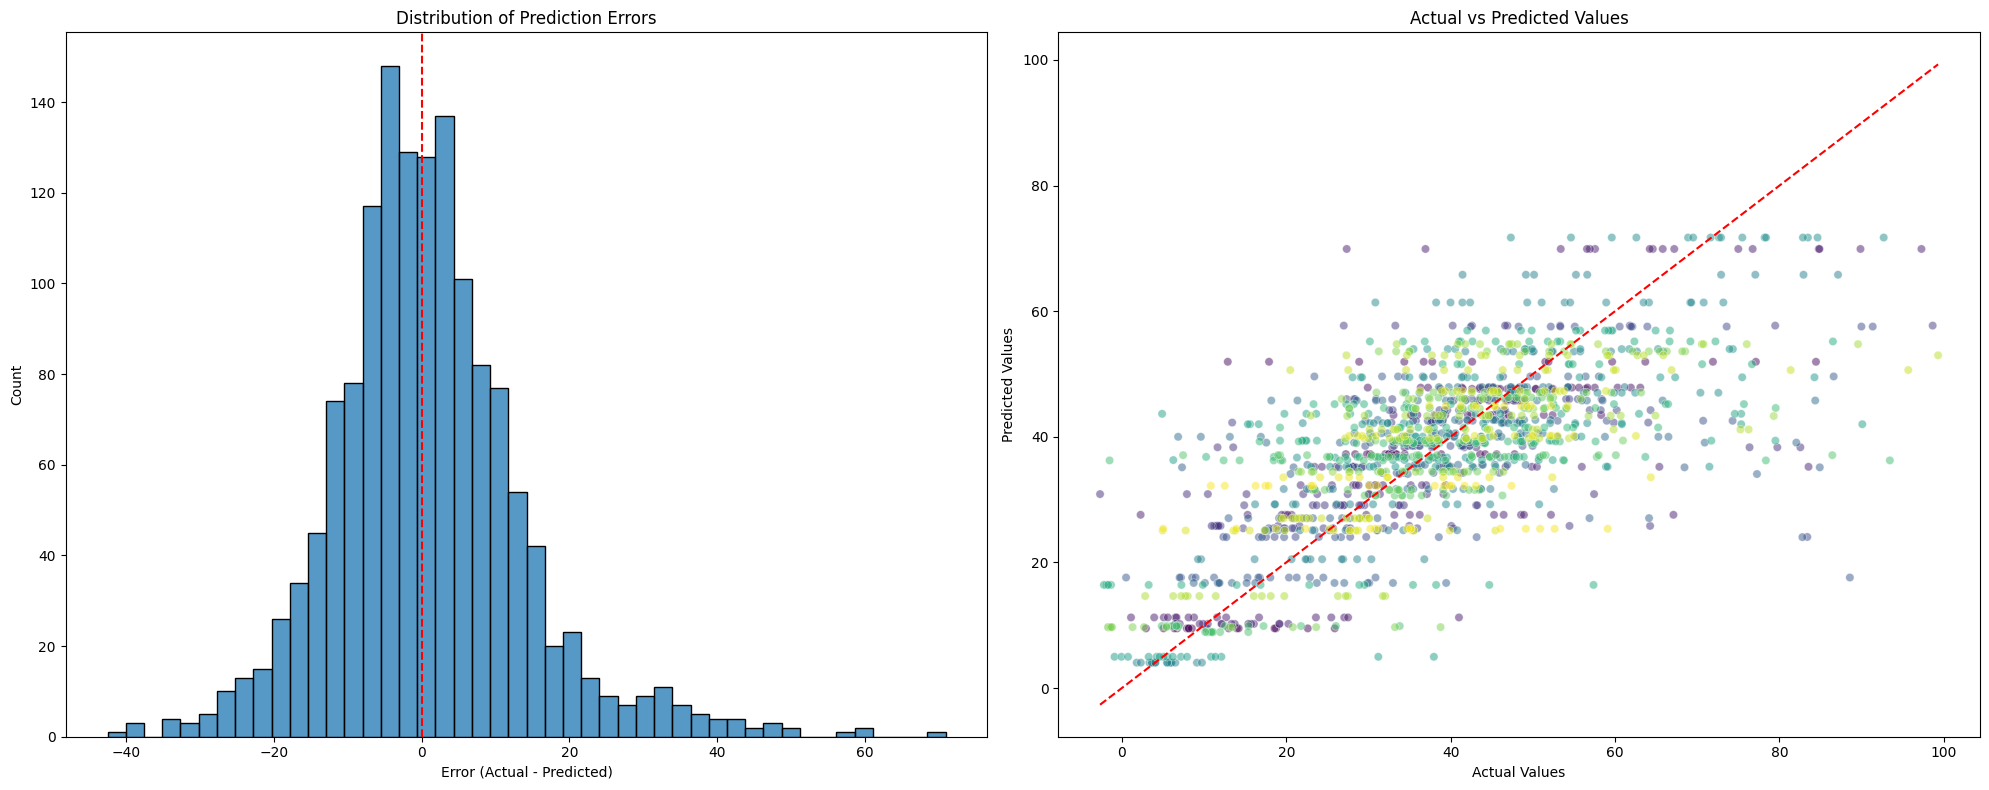

In [ ]:
# Drop NAs since not used for calculation
train_data_clean = train_data[[target, 'PID']].dropna()
test_data_clean = test_data[[target, 'PID']].dropna()

# Calculate median target value per subject from training data
train_medians = train_data_clean.groupby('PID')[target].median()

# Initialize predictions array
predictions = np.zeros(len(test_data_clean))

# Make predictions using each subject's median
for pid in test_data_clean['PID'].unique():
    # Get subject's data indices
    mask = test_data_clean['PID'] == pid
    
    # Use subject's training median if available, otherwise use overall median
    if pid in train_medians.index:
        subject_median = train_medians[pid]
    else:
        subject_median = train_data_clean[target].median()
        
    # Fill predictions for this subject
    predictions[mask] = subject_median

# Calculate metrics
mae = mean_absolute_error(test_data_clean[target], predictions)
rmse = np.sqrt(mean_squared_error(test_data_clean[target], predictions))
r2 = r2_score(test_data_clean[target], predictions)
mean_error = (mae + rmse)/2

# Print metrics
print(f"Baseline Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f'Mean error: {mean_error:.4f}')
print(f"R²: {r2:.4f}")

# Print data sizes
print(f"\nData sizes:")
print(f"Training samples: {len(train_data_clean)}")
print(f"Test samples: {len(test_data_clean)}")
print(f"Number of subjects in training: {len(train_data_clean['PID'].unique())}")
print(f"Number of subjects in test: {len(test_data_clean['PID'].unique())}")

# Plot diagnostics
plot_model_diagnostics(test_data_clean[target], predictions, test_data_clean)


## Group Level Models

### MLM Models

<div style="
    background-color:rgb(255, 245, 207);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>QUESTION</strong><br> <br>
        Is there a comprehensive way to iterate through all variable combinations to find the best overall model for a MLM with 3, 4, 5 features?
        <br><br>
        It seems like if you just go through all combinations it would take a LONG time to fit?
    </p>
</div>


In [226]:
target = 'target_wbw_gap_detrended'

In [227]:
train_data, test_data = create_train_test_split(df, target=target)

#### 1 Feature: Passive

In [228]:
# Find top passive feature with >1000 observations
top_passive = find_top_features(
    mlm1_4,
    n_predictors=1,
    data_modality='passive',
    min_observations=1000,
    sort_by='abs_z_score',
    top_n=1
)

Top 1 features for 1-predictor models with passive:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: passive_hk_activity_distanceWalkingRunning
abs_z_score: 6.573
z_score: -6.573
Number of observations: 1442


Model converged using lbfgs optimizer
                              Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          target_wbw_gap_detrended
No. Observations:           5907             Method:                      REML                    
No. Groups:                 104              Scale:                       180.9647                
Min. group size:            34               Log-Likelihood:              -23995.5325             
Max. group size:            61               Converged:                   Yes                     
Mean group size:            56.8                                                                  
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Int

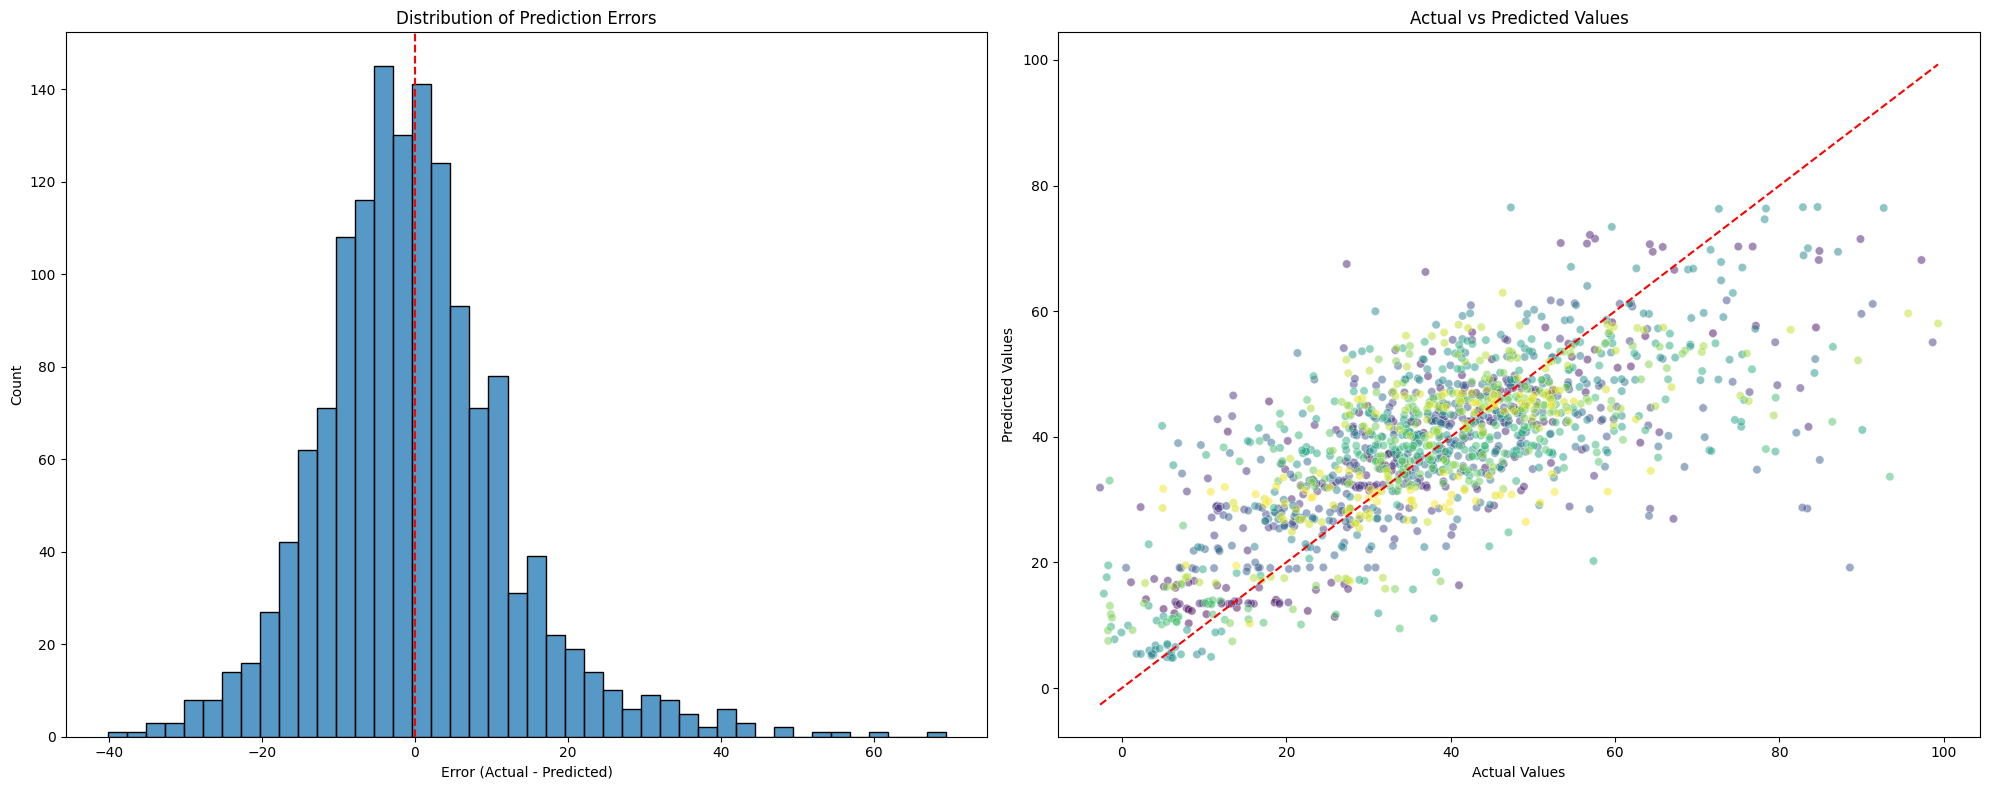

In [229]:
# Top passive feature MLM
predictors = ['passive_hk_activity_distanceWalkingRunning']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=None,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 1 Feature: Self Report

In [230]:
top_passive = find_top_features(
    mlm1_4,
    n_predictors=1,
    data_modality='sr',
    min_observations=1000,
    sort_by='abs_z_score',  # This is using raw z_score, not absolute
    top_n=1
)

Top 1 features for 1-predictor models with sr:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: sr_DAILY_past24_leisureSolo
abs_z_score: 7.892
z_score: 7.892
Number of observations: 1394


Model converged using lbfgs optimizer
                       Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     target_wbw_gap_detrended
No. Observations:      5752        Method:                 REML                    
No. Groups:            104         Scale:                  169.0375                
Min. group size:       22          Log-Likelihood:         -23171.7970             
Max. group size:       61          Converged:              Yes                     
Mean group size:       55.3                                                        
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                38.464    1.288 29.868 0.000 35.940 40.988
sr_DAILY_past24_leisureSolo               2.234    0.283  7.8

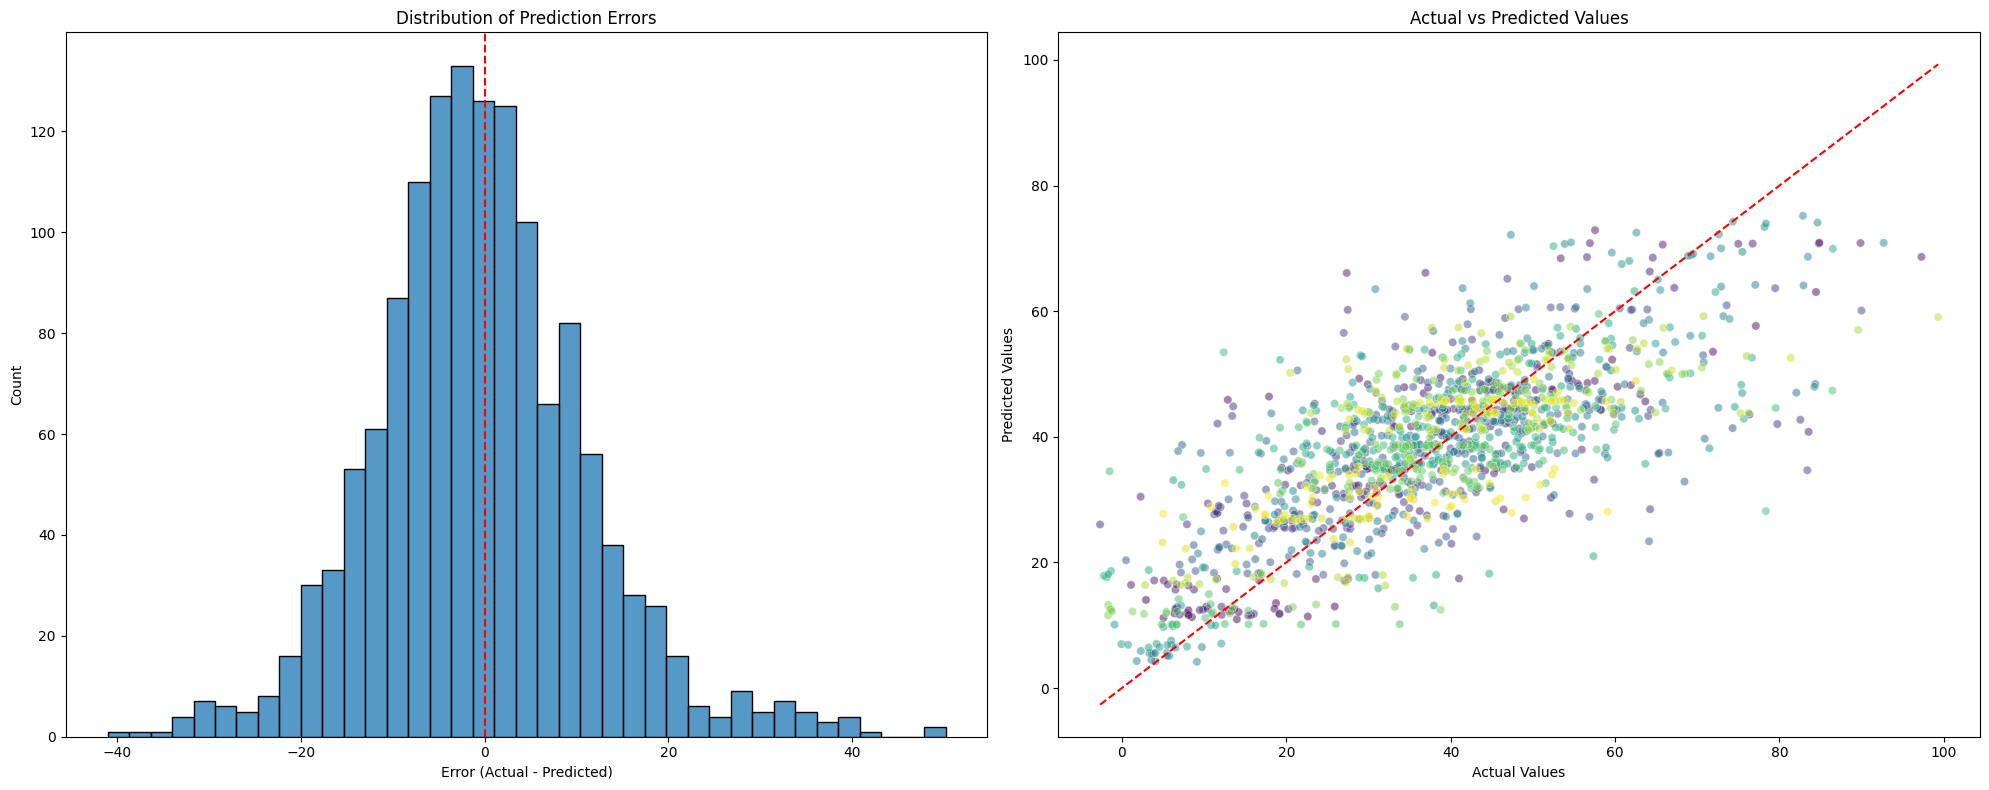

In [231]:
# Top sr feature MLM
predictors = ['sr_DAILY_past24_leisureSolo']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 1 Feature: Task

In [232]:
# Filter out rows containing task_motivation or nasa_ in feature_1
filtered_mlm1_4 = mlm1_4[~mlm1_4['feature_1'].str.contains('task_motivation|nasa_|task_start_time|task_end_time', na=False)]

top_passive = find_top_features(
    filtered_mlm1_4,
    n_predictors=1,
    data_modality='task',
    min_observations=1000,
    sort_by='abs_z_score',  # This is using raw z_score, not absolute
    top_n=2
)

Top 2 features for 1-predictor models with task:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: task_trailmaking_alphaNumeric_var
abs_z_score: 3.023
z_score: 3.023
Number of observations: 1372

Rank 2:
Feature 1: task_drift
abs_z_score: 2.895
z_score: -2.895
Number of observations: 1289


<div style="
    background-color:rgb(190, 240, 255);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>INFO</strong><br> <br>
        Here the second ranked feature was chosen just because it actually is a bit more interesting conceptually and performance on metrics other than absolute z-score is slightly better than the trailmaking feature."
    </p>
</div>


Model converged using lbfgs optimizer
                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_wbw_gap_detrended
No. Observations: 5817    Method:             REML                    
No. Groups:       104     Scale:              181.7664                
Min. group size:  27      Log-Likelihood:     -23608.5755             
Max. group size:  61      Converged:          Yes                     
Mean group size:  55.9                                                
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   38.544    1.284 30.029 0.000 36.029 41.060
task_drift                  -0.619    0.214 -2.895 0.004 -1.037 -0.200
Group Var                  168.030    1.786                           
Group x task_drift Cov       1.645    0.207             

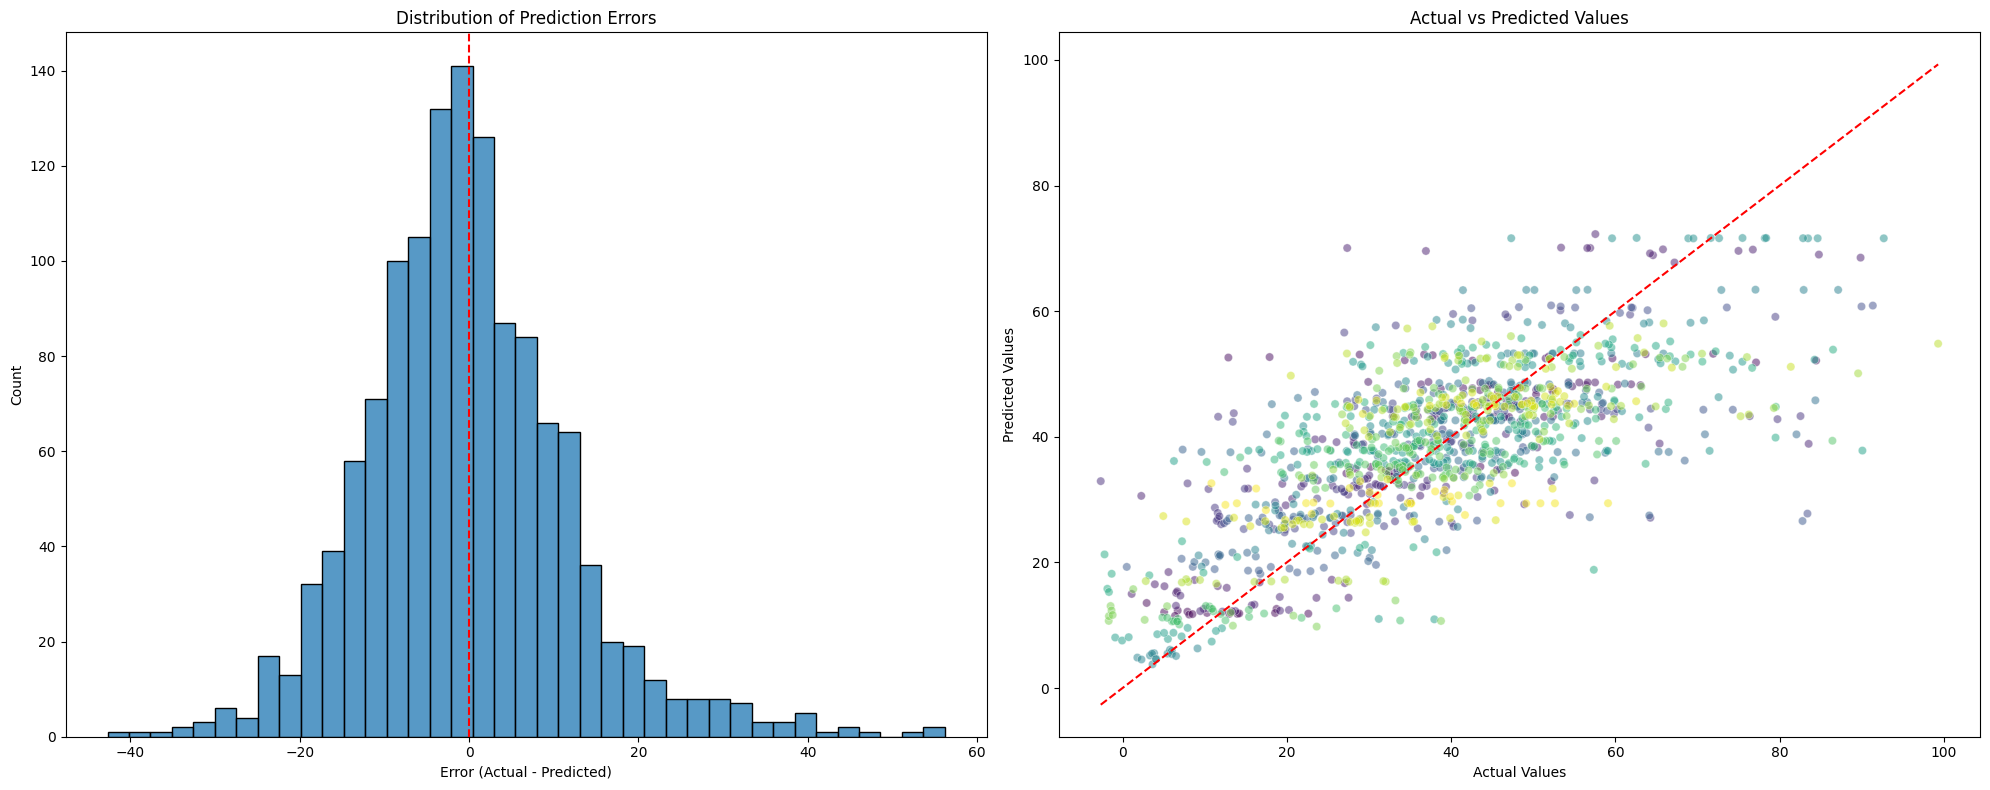

In [233]:
# Top sr feature MLM
predictors = ['task_drift']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Passive

In [234]:
# Filter out any rows containing task_start or task_end in feature columns
mlm1_4_filtered = mlm1_4[~mlm1_4[['feature_1', 'feature_2', 'feature_3', 'feature_4']].apply(
    lambda x: x.str.contains('task_start|task_end', na=False)).any(axis=1)]

top_passive = find_top_features(
    mlm1_4_filtered,
    n_predictors=2,
    data_modality='passive',
    min_observations=1000,
    sort_by='mean_error',  
    top_n=1
)

Top 1 features for 2-predictor models with passive:
Minimum observations: 1000, Sorted by: mean_error

Results:

Rank 1:
Feature 1: passive_hk_activity_steps
Feature 2: passive_hk_activity_appleStandTime
mean_error: 10.8330
Number of observations: 1012


<div style="
    background-color:rgb(255, 245, 207);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>QUESTION</strong><br> <br>
        Although I did an initial train test split that looked to do an 80/20 based on subjecs actual data, it seems like for some subjects for specific features they are missing quite a bit of data in the test set, making the number of observations specifically for the test set quite a bit lower (see the plot below).
        <br><br>
        Should the 80/20 split be conducted after selecting the features perhaps?
    </p>
</div>


<div style="
    background-color:rgb(253, 204, 204);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>NOTE</strong><br> <br>
         Below is an example where the recommended features seem to perform worse than alternate features that I know were individually predictive and don't seem likely to be as correlated as the two suggested features. However, as mentioned in the <strong>Question</strong> above perhaps this is just an artifact of less test data?
        <br> <br>
        Any ideas welcome!
    </p>
</div>


Model did not converge with lbfgs optimizer, trying next...
Model converged using nm optimizer
                                               Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     target_wbw_gap_detrended
No. Observations:                       5145                        Method:                                 REML                    
No. Groups:                             104                         Scale:                                  180.6907                
Min. group size:                        14                          Log-Likelihood:                         -20932.8025             
Max. group size:                        61                          Converged:                              Yes                     
Mean group size:                        49.5                                                                                        
----------------------

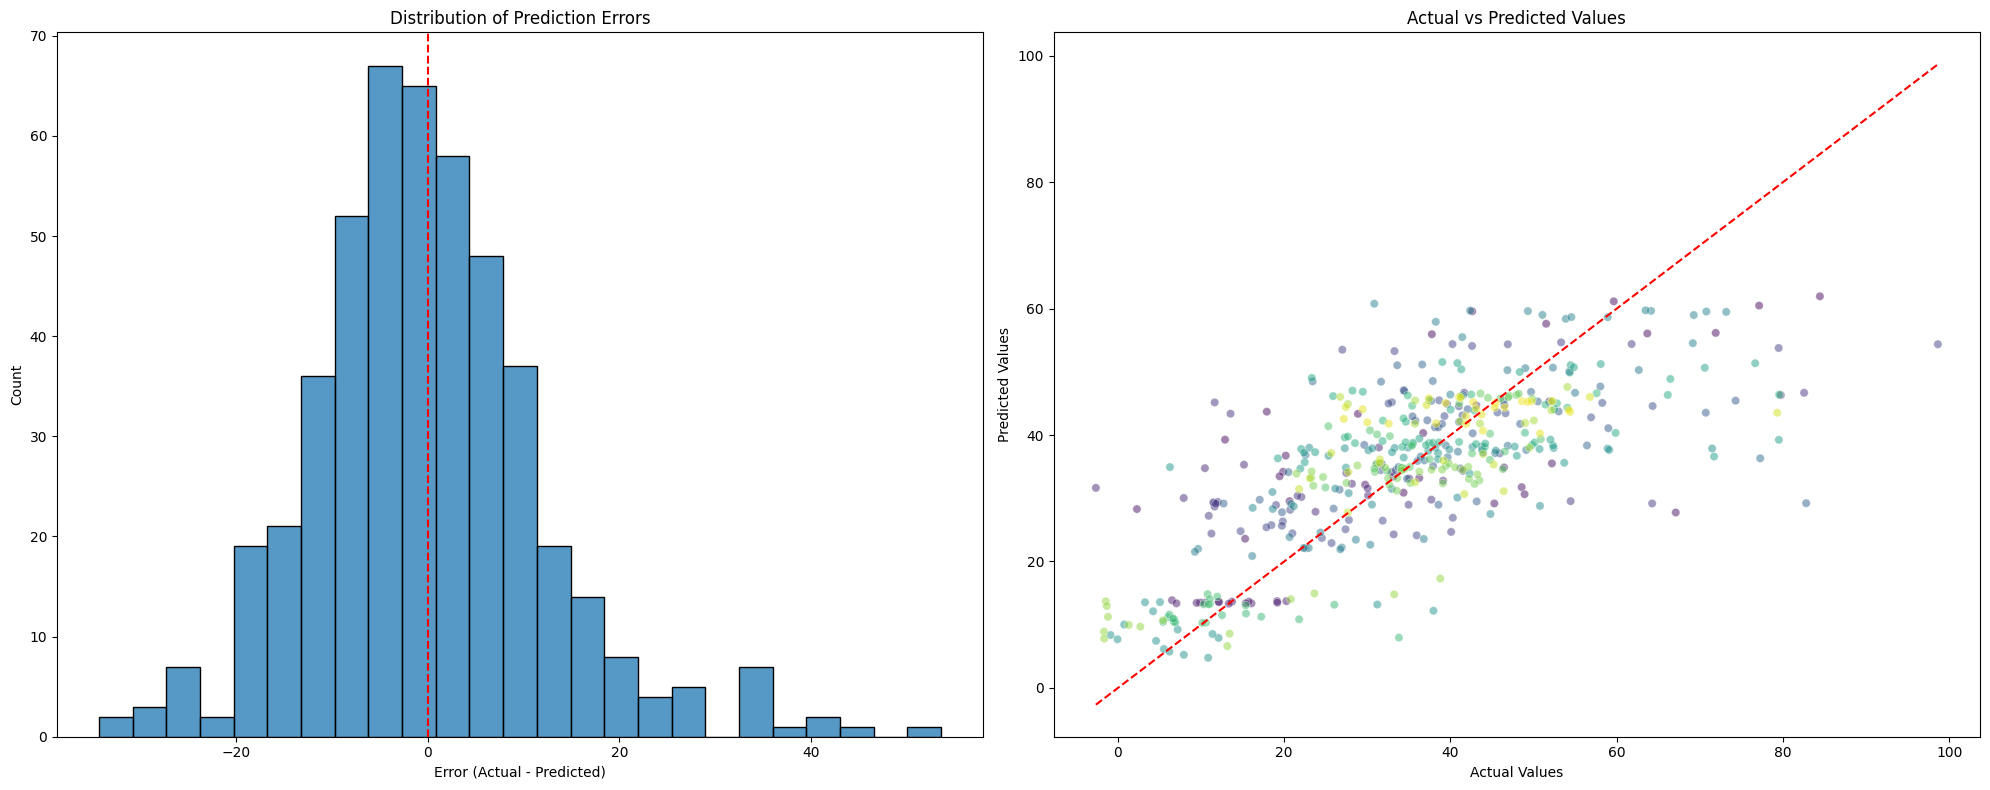

In [235]:
# Top passive feature MLM
# predictors = ['passive_hk_activity_steps', 'passive_hk_activity_appleStandTime'] 
# Alternate features chosen
predictors = ['passive_hk_activity_distanceWalkingRunning', 'passive_sk_device_total_unlock_duration']
# This performs even better but has less training data and even less test data...
# predictors = ['passive_hk_activity_appleStandTime', 'passive_sk_visits_home_elapsed']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Self Report

In [236]:
top_passive = find_top_features(
    mlm1_4,
    n_predictors=2,
    data_modality='self_report',
    min_observations=1000,
    sort_by='abs_z_score',  
    top_n=1
)

Top 1 features for 2-predictor models with self_report:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: sr_DAILY_past24_mentalEffort
Feature 2: sr_DAILY_past24_leisureNonSoloMental
abs_z_score: nan
z_score: nan
Number of observations: 1067


Model converged using lbfgs optimizer
                                       Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                target_wbw_gap_detrended
No. Observations:                4739                   Method:                            REML                    
No. Groups:                      103                    Scale:                             156.1270                
Min. group size:                 6                      Log-Likelihood:                    -18973.0057             
Max. group size:                 61                     Converged:                         Yes                     
Mean group size:                 46.0                                                                              
-------------------------------------------------------------------------------------------------------------------
                                                                         

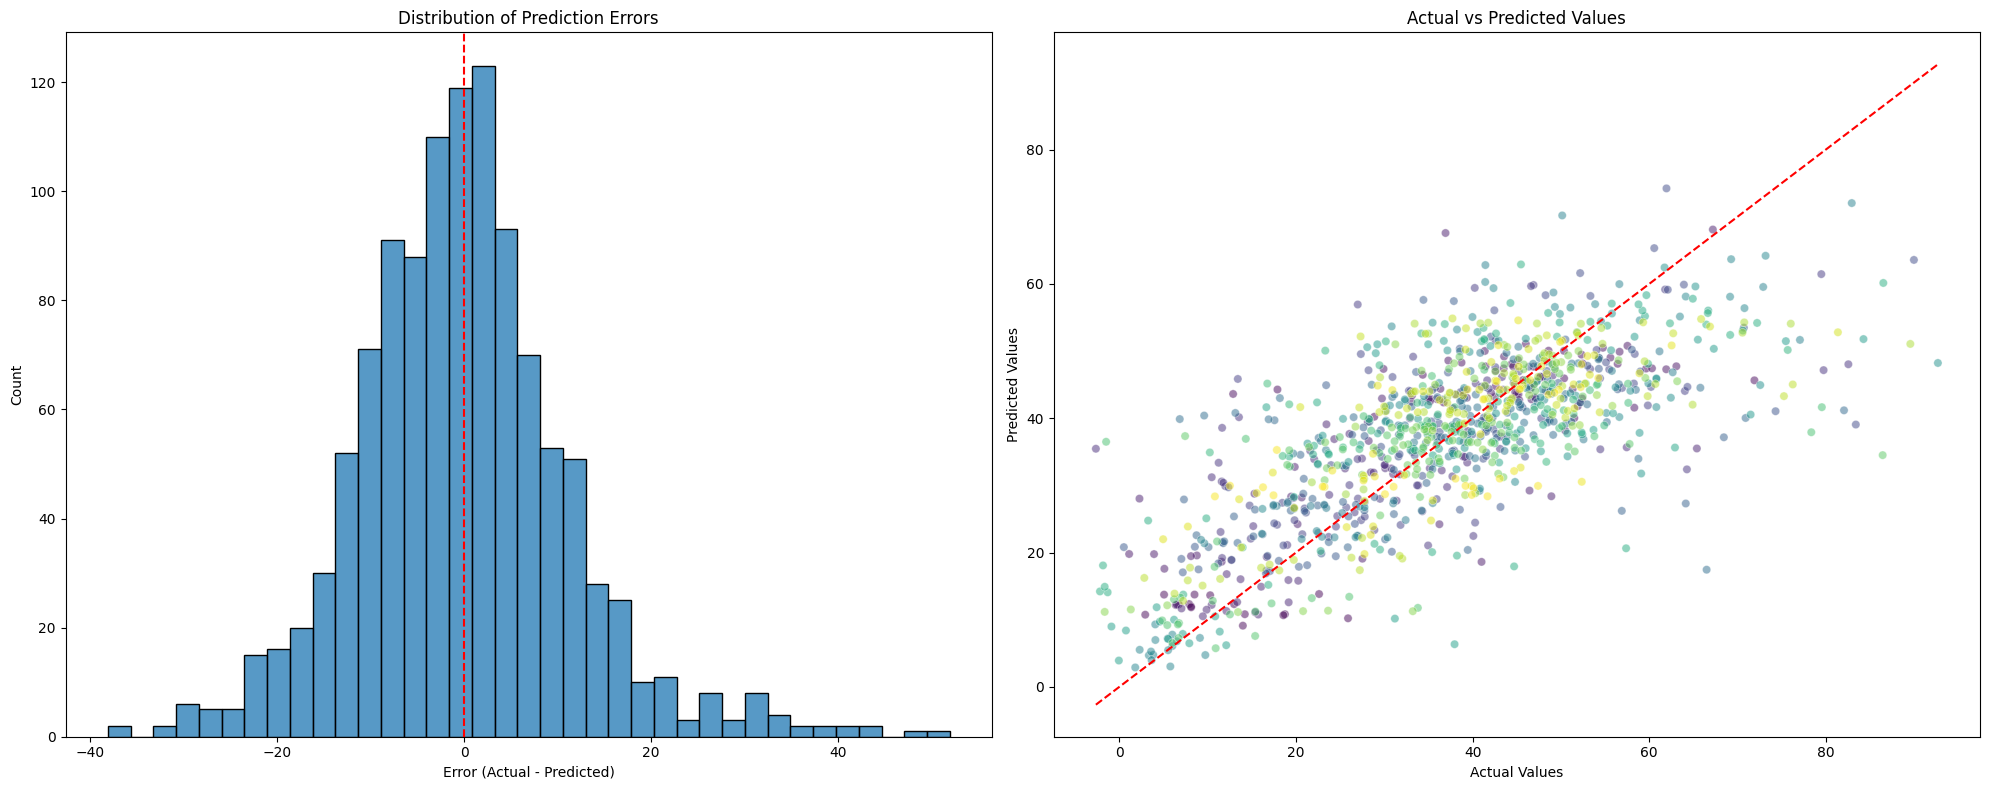

In [237]:
# Top passive feature MLM
predictors = ['sr_DAILY_past24_mentalEffort', 'sr_DAILY_past24_leisureNonSoloMental']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Passive + Self Report

Model converged using lbfgs optimizer
                                         Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 target_wbw_gap_detrended
No. Observations:                   5734                    Method:                             REML                    
No. Groups:                         104                     Scale:                              161.7229                
Min. group size:                    22                      Log-Likelihood:                     -23027.8844             
Max. group size:                    61                      Converged:                          Yes                     
Mean group size:                    55.1                                                                                
------------------------------------------------------------------------------------------------------------------------
                                    

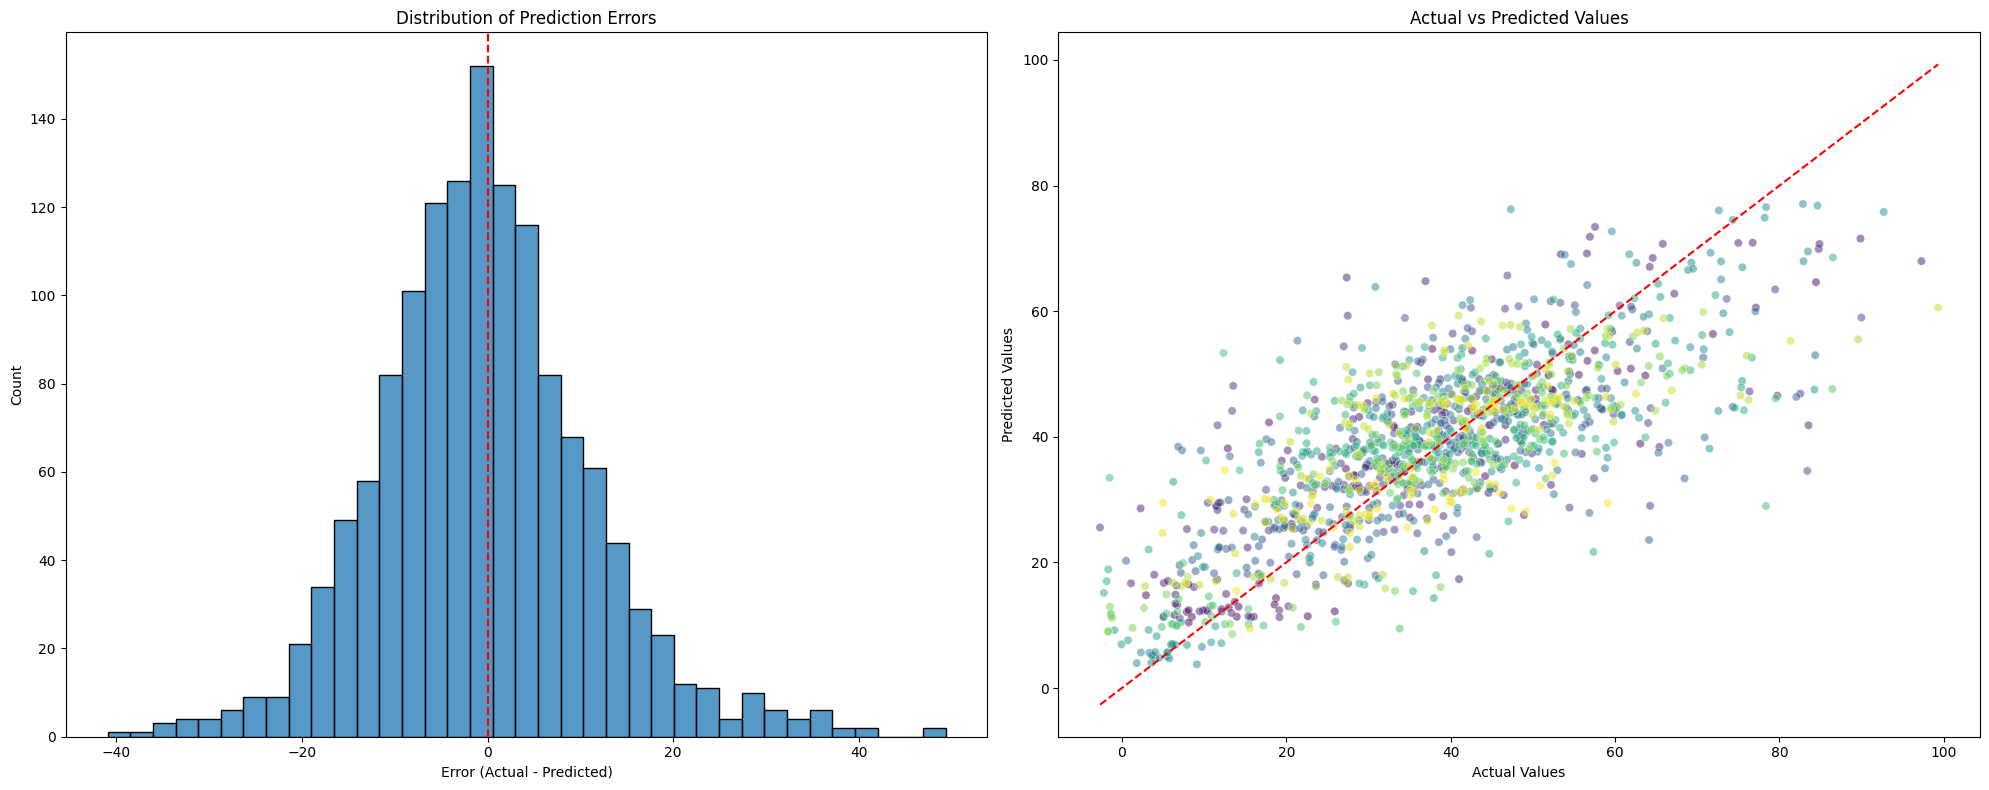

In [238]:
# Top passive feature MLM
predictors = ['sr_DAILY_past24_leisureSolo', 'passive_hk_activity_distanceWalkingRunning']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

### MLM Results

In [239]:
mlm_results = results.copy()
mlm_results.head(6)

,target,n_predictors,predictors,data_modality,n_observations_train,n_observations_test,mae,rmse,mean_error,r2,...,direction_ci_lower_train,direction_ci_upper_train,high_gap_precision_test,high_gap_recall_test,high_gap_f1_test,high_gap_accuracy_test,high_gap_precision_train,high_gap_recall_train,high_gap_f1_train,high_gap_accuracy_train
0,target_wbw_gap_detrended,1,[passive_hk_activity_distanceWalkingRunning],passive,5907,1442,9.331799,12.572895,10.952347,0.516924,...,0.536955,0.562985,0.396552,0.050773,0.090020,0.677531,0.485294,0.082008,0.140306,0.657694
1,target_wbw_gap_detrended,1,[sr_DAILY_past24_leisureSolo],sr,5752,1394,8.833590,11.694691,10.264141,0.554891,...,0.537890,0.565868,0.428571,0.069124,0.119048,0.681492,0.550388,0.108729,0.181586,0.666203
2,target_wbw_gap_detrended,1,[task_drift],task,5817,1289,9.055117,12.109772,10.582445,0.525997,...,0.517762,0.542806,0.555556,0.024752,0.047393,0.688130,0.493671,0.019687,0.037864,0.659275
3,target_wbw_gap_detrended,2,"[passive_hk_activity_distanceWalkingRunning, p...",passive,5145,479,9.003355,12.139074,10.571215,0.512453,...,0.540949,0.568141,0.521739,0.080000,0.138728,0.688935,0.484419,0.097547,0.162393,0.657143
4,target_wbw_gap_detrended,2,"[sr_DAILY_past24_mentalEffort, sr_DAILY_past24...",sr,4739,1132,8.496377,11.389728,9.943053,0.540642,...,0.566431,0.595341,0.378378,0.078873,0.130536,0.670495,0.540616,0.119801,0.196138,0.666174
5,target_wbw_gap_detrended,2,"[sr_DAILY_past24_leisureSolo, passive_hk_activ...",passive_sr,5734,1388,8.759933,11.552256,10.156094,0.566508,...,0.562340,0.588455,0.466667,0.097448,0.161228,0.685159,0.554307,0.151795,0.238325,0.670038


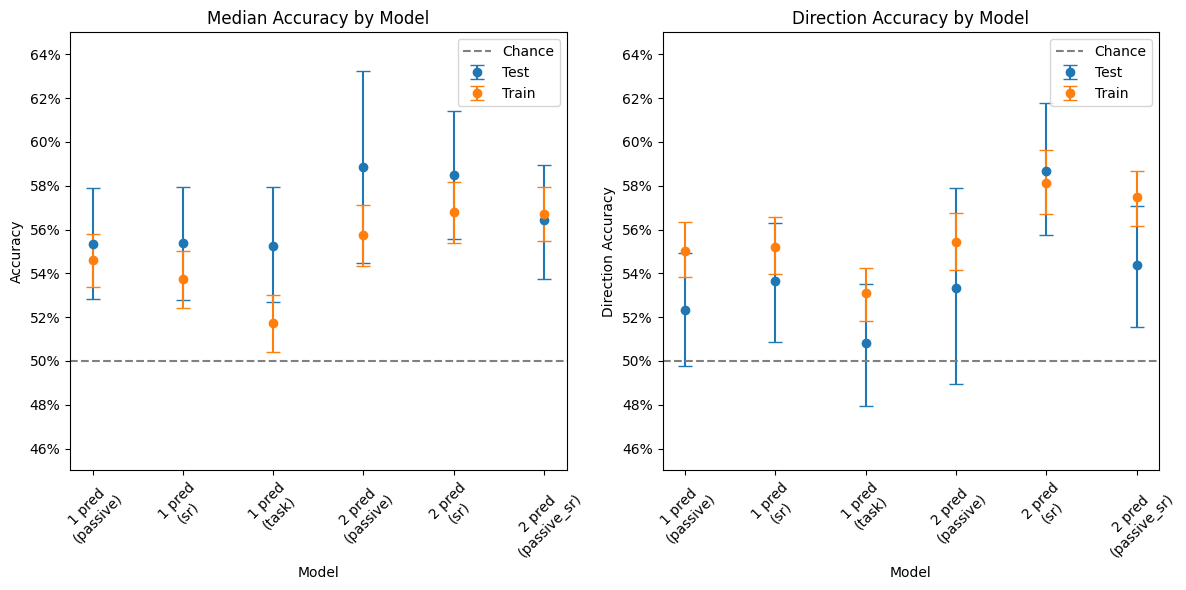

In [217]:
# Static plot
# Create figure
plt.figure(figsize=(12, 6))

# Plot median accuracy
plt.subplot(1, 2, 1)

# Add points and error bars for test accuracy
plt.errorbar(range(len(mlm_results)), 
            mlm_results['median_accuracy_test'],
            yerr=[mlm_results['median_accuracy_test'] - mlm_results['median_ci_lower_test'],
                  mlm_results['median_ci_upper_test'] - mlm_results['median_accuracy_test']],
            fmt='o', label='Test', capsize=5)

# Add points and error bars for train accuracy
plt.errorbar(range(len(mlm_results)),
            mlm_results['median_accuracy_train'], 
            yerr=[mlm_results['median_accuracy_train'] - mlm_results['median_ci_lower_train'],
                  mlm_results['median_ci_upper_train'] - mlm_results['median_accuracy_train']],
            fmt='o', label='Train', capsize=5)

# Add chance line
plt.axhline(y=0.5, color='gray', linestyle='--', label='Chance')

# Customize plot
plt.title('Median Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.45, 0.65)  # Set consistent y-axis limits
# Set y-ticks as percentages from 46% to 64% in 2% increments
plt.yticks(np.arange(0.46, 0.65, 0.02), [f"{int(y*100)}%" for y in np.arange(0.46, 0.65, 0.02)])

# Create labels combining n_predictors and data_modality
labels = [f"{row['n_predictors']} pred\n({row['data_modality']})" 
          for _, row in mlm_results.iterrows()]
plt.xticks(range(len(mlm_results)), labels, rotation=45)

# Plot direction accuracy
plt.subplot(1, 2, 2)

# Add points and error bars for test direction accuracy
plt.errorbar(range(len(mlm_results)),
            mlm_results['direction_accuracy_test'],
            yerr=[mlm_results['direction_accuracy_test'] - mlm_results['direction_ci_lower_test'],
                  mlm_results['direction_ci_upper_test'] - mlm_results['direction_accuracy_test']],
            fmt='o', label='Test', capsize=5)

# Add points and error bars for train direction accuracy  
plt.errorbar(range(len(mlm_results)),
            mlm_results['direction_accuracy_train'],
            yerr=[mlm_results['direction_accuracy_train'] - mlm_results['direction_ci_lower_train'],
                  mlm_results['direction_ci_upper_train'] - mlm_results['direction_accuracy_train']],
            fmt='o', label='Train', capsize=5)

# Add chance line
plt.axhline(y=0.5, color='gray', linestyle='--', label='Chance')

# Customize plot
plt.title('Direction Accuracy by Model')
plt.xlabel('Model') 
plt.ylabel('Direction Accuracy')
plt.legend()
plt.ylim(0.45, 0.65)  # Set consistent y-axis limits
# Set y-ticks as percentages from 46% to 64% in 2% increments
plt.yticks(np.arange(0.46, 0.65, 0.02), [f"{int(y*100)}%" for y in np.arange(0.46, 0.65, 0.02)])
plt.xticks(range(len(mlm_results)), labels, rotation=45)

plt.tight_layout()
plt.show()

In [218]:
# Interactive plot
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Above/Below Median Accuracy', 'Daily Change Direction Accuracy'))

# Create labels combining n_predictors and data_modality
labels = [f"{row['n_predictors']} pred\n({row['data_modality']})" 
          for _, row in mlm_results.iterrows()]

# Function to clean predictor names
def clean_predictor_name(name):
    return name.replace('passive_hk_', '').replace('passive_sk_', '').replace('sr_DAILY_', '').split(',')[0]

# Plot 1: Median Accuracy
# Test accuracy
fig.add_trace(
    go.Scatter(
        x=list(range(len(mlm_results))),
        y=mlm_results['median_accuracy_test'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=mlm_results['median_ci_upper_test'] - mlm_results['median_accuracy_test'],
            arrayminus=mlm_results['median_accuracy_test'] - mlm_results['median_ci_lower_test']
        ),
        mode='markers',
        name='Test',
        marker=dict(color='#1f77b4'),  # Blue
        hovertemplate=(
            "<b>Predictors:</b><br>" +
            "%{customdata[0]}<br>" +
            "<b>Mean</b>: %{y:.1%} (95% CI [%{customdata[1]:.1%}, %{customdata[2]:.1%}])<br>" +
            "<extra></extra>"
        ),
        customdata=[['\n'.join([f"{i+1}. {clean_predictor_name(p)}<br>" for i, p in enumerate(pred)]), ci_l, ci_u] 
                   for pred, ci_l, ci_u in zip(mlm_results['predictors'], 
                                             mlm_results['median_ci_lower_test'],
                                             mlm_results['median_ci_upper_test'])],
        showlegend=True
    ),
    row=1, col=1
)

# Train accuracy
fig.add_trace(
    go.Scatter(
        x=list(range(len(mlm_results))),
        y=mlm_results['median_accuracy_train'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=mlm_results['median_ci_upper_train'] - mlm_results['median_accuracy_train'],
            arrayminus=mlm_results['median_accuracy_train'] - mlm_results['median_ci_lower_train']
        ),
        mode='markers',
        name='Train',
        marker=dict(color='#9467bd'),  # Purple
        hovertemplate=(
            "<b>Predictors:</b><br>" +
            "%{customdata[0]}<br>" +
            "<b>Mean</b>: %{y:.1%} (95% CI [%{customdata[1]:.1%}, %{customdata[2]:.1%}])<br>" +
            "<extra></extra>"
        ),
        customdata=[['\n'.join([f"{i+1}. {clean_predictor_name(p)}<br>" for i, p in enumerate(pred)]), ci_l, ci_u]
                   for pred, ci_l, ci_u in zip(mlm_results['predictors'], 
                                             mlm_results['median_ci_lower_train'],
                                             mlm_results['median_ci_upper_train'])],
        showlegend=True
    ),
    row=1, col=1
)

# Plot 2: Direction Accuracy
# Test direction accuracy
fig.add_trace(
    go.Scatter(
        x=list(range(len(mlm_results))),
        y=mlm_results['direction_accuracy_test'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=mlm_results['direction_ci_upper_test'] - mlm_results['direction_accuracy_test'],
            arrayminus=mlm_results['direction_accuracy_test'] - mlm_results['direction_ci_lower_test']
        ),
        mode='markers',
        name='Test',
        marker=dict(color='#1f77b4'),  # Blue
        hovertemplate=(
            "<b>Predictors:</b><br>" +
            "%{customdata[0]}<br>" +
            "<b>Mean</b>: %{y:.1%} (95% CI [%{customdata[1]:.1%}, %{customdata[2]:.1%}])<br>" +
            "<extra></extra>"
        ),
        customdata=[['\n'.join([f"{i+1}. {clean_predictor_name(p)}<br>" for i, p in enumerate(pred)]), ci_l, ci_u]
                   for pred, ci_l, ci_u in zip(mlm_results['predictors'],
                                             mlm_results['direction_ci_lower_test'],
                                             mlm_results['direction_ci_upper_test'])],
        showlegend=False
    ),
    row=1, col=2
)

# Train direction accuracy
fig.add_trace(
    go.Scatter(
        x=list(range(len(mlm_results))),
        y=mlm_results['direction_accuracy_train'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=mlm_results['direction_ci_upper_train'] - mlm_results['direction_accuracy_train'],
            arrayminus=mlm_results['direction_accuracy_train'] - mlm_results['direction_ci_lower_train']
        ),
        mode='markers',
        name='Train',
        marker=dict(color='#9467bd'),  # Purple
        hovertemplate=(
            "<b>Predictors:</b><br>" +
            "%{customdata[0]}<br>" +
            "<b>Mean</b>: %{y:.1%} (95% CI [%{customdata[1]:.1%}, %{customdata[2]:.1%}])<br>" +
            "<extra></extra>"
        ),
        customdata=[['\n'.join([f"{i+1}. {clean_predictor_name(p)}<br>" for i, p in enumerate(pred)]), ci_l, ci_u]
                   for pred, ci_l, ci_u in zip(mlm_results['predictors'],
                                             mlm_results['direction_ci_lower_train'],
                                             mlm_results['direction_ci_upper_train'])],
        showlegend=False
    ),
    row=1, col=2
)

# Chance lines
fig.add_hline(y=0.5, line_dash="dash", line_color="gray", row=1, col=1)
fig.add_hline(y=0.5, line_dash="dash", line_color="gray", row=1, col=2)

# Update layout with reduced size
fig.update_layout(
    template='plotly_white',  # Add plotly_white theme
    height=420,  # 70% of original 600
    width=840,   # 70% of original 1200
    showlegend=True,
    xaxis=dict(
        ticktext=labels,
        tickvals=list(range(len(labels))),
        tickangle=45
    ),
    xaxis2=dict(
        ticktext=labels,
        tickvals=list(range(len(labels))),
        tickangle=45
    ),
    yaxis=dict(
        range=[0.45, 0.65],
        tickformat='.0%',
        title='Accuracy'
    ),
    yaxis2=dict(
        range=[0.45, 0.65],
        tickformat='.0%',
        title='Accuracy'
    )
)

fig.show()

### XGBoost

In [258]:
def create_expanding_window_splits(data, initial_val_size=10, window_size=2):
    """
    Create expanding window splits within each subject
    """
    splits = []
    
    for _ in range(5):  # 5 splits as specified
        train_indices = []
        val_indices = []
        
        for pid in data['PID'].unique():
            # Get subject's data indices
            subject_data = data[data['PID'] == pid]
            subject_indices = subject_data.index.tolist()
            
            if len(subject_indices) < initial_val_size + window_size:
                continue
                
            # Calculate split points
            n_train = len(subject_indices) - initial_val_size
            current_split = len(splits)
            val_start = n_train + (current_split * window_size)
            val_end = val_start + window_size
            
            # Add indices to appropriate sets
            train_indices.extend(subject_indices[:val_start])
            val_indices.extend(subject_indices[val_start:val_end])
        
        splits.append((train_indices, val_indices))
    
    return splits

def normalize_features_for_split(train_data, val_data, predictors, subject_col='PID'):
    """
    Normalize features within subject using only training data statistics
    """
    # Create explicit copies to preserve all columns
    train_normalized = train_data.copy()
    val_normalized = val_data.copy()
    norm_params = {}
    
    # Only normalize predictor columns
    for pid in train_data[subject_col].unique():
        train_mask = train_data[subject_col] == pid
        val_mask = val_data[subject_col] == pid
        
        for predictor in predictors:
            # Calculate parameters from training data only
            mean = train_data.loc[train_mask, predictor].mean()
            std = train_data.loc[train_mask, predictor].std()
            if std == 0:
                std = 1
                
            # Store parameters
            if pid not in norm_params:
                norm_params[pid] = {}
            norm_params[pid][predictor] = {'mean': mean, 'std': std}
            
            # Apply normalization only to predictor columns
            train_normalized.loc[train_mask, predictor] = (train_data.loc[train_mask, predictor] - mean) / std
            if val_mask.any():
                val_normalized.loc[val_mask, predictor] = (val_data.loc[val_mask, predictor] - mean) / std
    
    return train_normalized, val_normalized, norm_params

def select_valid_subjects(train_data, test_data, target, min_train_rows=40, min_test_rows=8):
    """
    Select subjects that meet minimum data requirements in both training and test sets.
    
    Args:
        train_data (pd.DataFrame): Training data
        test_data (pd.DataFrame): Test data
        target (str): Name of target variable
        min_train_rows (int): Minimum number of rows required in training data per subject
        min_test_rows (int): Minimum number of rows required in test data per subject
        
    Returns:
        tuple: (filtered_train_data, filtered_test_data, valid_subjects)
    """
    # Drop rows where target is NA (we are not imputing target)
    train_data_clean = train_data.dropna(subset=[target])
    test_data_clean = test_data.dropna(subset=[target])
    
    # Get subjects that have minimum required rows in training data
    train_subject_counts = train_data_clean.groupby('PID').size()
    valid_train_subjects = train_subject_counts[train_subject_counts >= min_train_rows].index.tolist()
    
    # Get subjects that have minimum required rows in test data
    test_subject_counts = test_data_clean.groupby('PID').size()
    valid_test_subjects = test_subject_counts[test_subject_counts >= min_test_rows].index.tolist()
    
    # Get intersection of valid subjects from both train and test
    valid_subjects = list(set(valid_train_subjects) & set(valid_test_subjects))
    
    # Filter data to only include valid subjects
    train_data_clean = train_data_clean[train_data_clean['PID'].isin(valid_subjects)]
    test_data_clean = test_data_clean[test_data_clean['PID'].isin(valid_subjects)]
    
    return train_data_clean, test_data_clean, valid_subjects

def impute_time_series_data(train_data, test_data, predictors, subject_col='PID', day_col='day', max_gap=7):
    """
    Impute missing values in time series data using within-subject forward/backward fill
    and mean imputation, while respecting time gaps.
    """
    # Create explicit copies at the start
    train_imputed = train_data.copy()
    test_imputed = test_data.copy()
    
    # Calculate global means from training data for each predictor
    train_global_means = train_data[predictors].mean()
    
    # Process each subject separately
    for pid in train_data[subject_col].unique():
        # Get subject data masks
        train_mask = train_data[subject_col] == pid
        test_mask = test_data[subject_col] == pid
        
        # Create complete copies of subject data
        train_subject = train_data[train_mask].copy()
        test_subject = test_data[test_mask].copy() if test_mask.any() else None
        
        # Sort by day
        train_subject = train_subject.sort_values(day_col)
        if test_subject is not None:
            test_subject = test_subject.sort_values(day_col)
        
        # Process each predictor
        for predictor in predictors:
            # Create a copy of the series to modify
            series = train_subject[predictor].copy()
            
            # Forward fill within max_gap
            for idx in range(len(series)):
                if pd.isna(series.iloc[idx]):
                    for look_back in range(idx-1, max(-1, idx-max_gap-1), -1):
                        if look_back >= 0 and not pd.isna(series.iloc[look_back]):
                            days_gap = train_subject[day_col].iloc[idx] - train_subject[day_col].iloc[look_back]
                            if days_gap <= max_gap:
                                series.iloc[idx] = series.iloc[look_back]
                            break
            
            # Backward fill within max_gap
            for idx in range(len(series)-1, -1, -1):
                if pd.isna(series.iloc[idx]):
                    for look_forward in range(idx+1, min(len(series), idx+max_gap+1)):
                        if not pd.isna(series.iloc[look_forward]):
                            days_gap = train_subject[day_col].iloc[look_forward] - train_subject[day_col].iloc[idx]
                            if days_gap <= max_gap:
                                series.iloc[idx] = series.iloc[look_forward]
                            break
            
            # Fill remaining missing values with subject mean or global mean
            subject_mean = series.mean()
            if pd.isna(subject_mean):
                subject_mean = train_global_means[predictor]
            series = series.fillna(subject_mean)
            
            # Update the data using loc
            train_imputed.loc[train_mask, predictor] = series.values
            
            # Test data imputation
            if test_subject is not None:
                test_series = test_subject[predictor].copy()
                
                # Forward fill from training data if within max_gap
                last_train_day = train_subject[day_col].iloc[-1]
                last_train_value = series.iloc[-1]
                
                for idx in range(len(test_series)):
                    if pd.isna(test_series.iloc[idx]):
                        days_gap = test_subject[day_col].iloc[idx] - last_train_day
                        if days_gap <= max_gap:
                            test_series.iloc[idx] = last_train_value
                
                # Forward and backward fill within test data
                test_series = test_series.ffill(limit=max_gap)
                test_series = test_series.bfill(limit=max_gap)
                
                # Fill remaining missing values with subject mean
                test_series = test_series.fillna(subject_mean)
                
                # Update the test data using loc
                test_imputed.loc[test_mask, predictor] = test_series.values
    
    return train_imputed, test_imputed

In [259]:
def train_xgboost_model(predictors, target, train_data, test_data, 
                        add_sub_target_stats=True, metric='average', n_trials=100):
    """
    Train an XGBoost model with hyperparameter optimization and feature normalization.
    
    Args:
        predictors (list): List of predictor column names
        target (str): Name of target variable
        train_data (pd.DataFrame): Training data
        test_data (pd.DataFrame): Test data
        add_sub_target_stats (bool): Whether to add subject-level target statistics as features
        metric (str): Optimization metric ('rmse', 'mae', or 'average')
        n_trials (int): Number of optimization trials
        
    Returns:
        dict: Dictionary containing model results and metrics
    """
    ###################
    # Select Subjects #
    ###################
    train_data_clean, test_data_clean, valid_subjects = select_valid_subjects(
        train_data,
        test_data,
        target=target,
        min_train_rows=40,
        min_test_rows=8
    )
    
    ##############
    # Imputation #
    ##############
    train_data_clean, test_data_clean = impute_time_series_data(
        train_data_clean,
        test_data_clean,
        predictors,
        max_gap=7 
    )
    
    # Extra check to ensure no NaN, inf, or extreme values in target
    train_data_clean = train_data_clean[~train_data_clean[target].isna()]
    train_data_clean = train_data_clean[~np.isinf(train_data_clean[target])]
    test_data_clean = test_data_clean[~test_data_clean[target].isna()]
    test_data_clean = test_data_clean[~np.isinf(test_data_clean[target])]
    
    # Check for and remove extreme values if needed
    max_val = 1e9  # Adjust as needed
    train_data_clean = train_data_clean[np.abs(train_data_clean[target]) < max_val]
    test_data_clean = test_data_clean[np.abs(test_data_clean[target]) < max_val]

    # Define objective function with access to predictors
    def objective(trial, add_subject_stats=True, metric='rmse'):
        """
        Objective function for hyperparameter optimization
        
        Args:
            trial: Optuna trial object
            add_subject_stats: Whether to add subject-level statistics as features
            metric: One of 'rmse', 'mae', or 'average' to determine optimization metric
        """
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
            'random_state': 42,
            'n_jobs': -1, # use all cores
            'early_stopping_rounds': 20
        }
        
        # Store validation RMSEs for each split
        split_metrics = []
        
        # Create expanding window splits
        splits = create_expanding_window_splits(train_data_clean)
        
        # Evaluate each split
        for train_idx, val_idx in splits:
            # Get split data
            split_train = train_data_clean.loc[train_idx]
            split_val = train_data_clean.loc[val_idx]
            
            # Normalize features (excluding subject_median which hasn't been created yet)
            split_train_norm, split_val_norm, _ = normalize_features_for_split(
                split_train, 
                split_val, 
                predictors,  # Now predictors is properly defined
                subject_col='PID'
            )
            
            # Initialize feature columns list
            feature_cols = predictors.copy()
            
            if add_subject_stats:
                # Calculate and add subject statistics from training data
                train_medians = split_train_norm[target].groupby(split_train_norm['PID']).median()
                train_stds = split_train_norm[target].groupby(split_train_norm['PID']).std()
                
                # Add subject median and std as features
                split_train_norm['subject_median'] = split_train_norm['PID'].map(train_medians)
                split_val_norm['subject_median'] = split_val_norm['PID'].map(train_medians)
                split_train_norm['subject_std'] = split_train_norm['PID'].map(train_stds)
                split_val_norm['subject_std'] = split_val_norm['PID'].map(train_stds)
                
                # Handle any missing values
                split_val_norm['subject_median'].fillna(train_medians.mean(), inplace=True)
                split_val_norm['subject_std'].fillna(train_stds.mean(), inplace=True)
                
                # Add to feature columns
                feature_cols.extend(['subject_median', 'subject_std'])

            X_train_split = split_train_norm[feature_cols]
            y_train_split = split_train_norm[target]
            X_val_split = split_val_norm[feature_cols]
            y_val_split = split_val_norm[target]
            
            # Train model
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train_split,
                y_train_split,
                eval_set=[(X_val_split, y_val_split)],
                verbose=False
            )
            
            # Get predictions and calculate RMSE
            val_preds = model.predict(X_val_split)
            split_rmse = np.sqrt(mean_squared_error(y_val_split, val_preds))
            split_mae = mean_absolute_error(y_val_split, val_preds)
            
            if metric == 'rmse':
                split_metrics.append(split_rmse)
            elif metric == 'mae':
                split_metrics.append(split_mae)
            else:  # average
                split_metrics.append((split_rmse + split_mae) / 2)
        
        # Return average metric across all splits
        return np.mean(split_metrics)

    #################################################
    # Cross validation for hyperparameter selection #
    #################################################
    print(f"Optimizing hyperparameters using {metric.upper()}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, add_subject_stats=add_sub_target_stats, metric=metric), 
                  n_trials=n_trials,
                  show_progress_bar=True
                  )

    # Get best parameters
    best_params = study.best_params

    #######################################
    # Fit model with best hyperparameters #
    #######################################
    
    # Normalize complete training data and test data
    train_norm, test_norm, norm_params = normalize_features_for_split(
        train_data_clean,
        test_data_clean,
        predictors
    )
    
    # Initialize feature columns
    feature_cols = predictors.copy()

    # Add subject statistics if requested
    if add_sub_target_stats:
        # Calculate and add subject statistics from training data
        train_medians = train_norm[target].groupby(train_norm['PID']).median()
        train_stds = train_norm[target].groupby(train_norm['PID']).std()
        
        # Add to training data
        train_norm['subject_median'] = train_norm['PID'].map(train_medians)
        train_norm['subject_std'] = train_norm['PID'].map(train_stds)
        
        # Add to test data
        test_norm['subject_median'] = test_norm['PID'].map(train_medians)
        test_norm['subject_std'] = test_norm['PID'].map(train_stds)
        
        # Handle missing values in test set
        test_norm['subject_median'].fillna(train_medians.mean(), inplace=True)
        test_norm['subject_std'].fillna(train_stds.mean(), inplace=True)
        
        # Add to feature columns
        feature_cols.extend(['subject_median', 'subject_std'])

    # Prepare final training and test data
    X_train = train_norm[feature_cols]
    y_train = train_norm[target]
    X_test = test_norm[feature_cols]
    y_test = test_norm[target]

    # Train final model with best parameters
    final_params = best_params.copy()
    final_model = xgb.XGBRegressor(**final_params)
    final_model.fit(
        X_train,
        y_train,
        verbose=False
    )

    # Make predictions on test set
    predictions = final_model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    # Calculate above/below median accuracy
    above_median_correct = 0
    total_predictions = 0

    for pid in test_norm['PID'].unique():
        mask = test_norm['PID'] == pid
        if pid in train_medians.index:
            subject_median = train_medians[pid]
            subject_actual = y_test[mask]
            subject_predicted = predictions[mask]
            
            actual_above = subject_actual > subject_median
            pred_above = subject_predicted > subject_median
            
            above_median_correct += np.sum(actual_above == pred_above)
            total_predictions += len(subject_actual)

    median_accuracy = above_median_correct / total_predictions if total_predictions > 0 else 0

    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Return results
    results = {
        'model': final_model,
        'predictions': predictions,
        'y_test': y_test,
        'metrics': {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'median_accuracy': median_accuracy
        },
        'data_sizes': {
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'n_subjects': len(valid_subjects)
        },
        'feature_importance': feature_importance,
        'best_params': best_params
    }
    
    return results

<div style="
    background-color:rgb(255, 245, 207);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>QUESTION</strong><br> <br>
        I am subselecting features that actually had meaningful predictive power in the MLM.
        <br><br>
        Not sure if this is a necessary step? Thought was just to reduce the dimensionality a bit. 
        <br><br>
        Should consider removing highly correlated features?
    </p>
</div>


In [243]:
# Filter MLM results for n_observations>1000, single predictor, and significant z-score
mlm_results_1000_z2_1pred = mlm1_4.loc[(mlm1_4['n_observations']>1000) & 
                                           (mlm1_4['n_predictors']==1) &
                                           (abs(mlm1_4['z_score'])>2)]

# Create lists of features for each modality
task_1000_z2 = mlm_results_1000_z2_1pred[mlm_results_1000_z2_1pred.data_modality == 'task'].feature_1.tolist()
sr_1000_z2 = mlm_results_1000_z2_1pred[mlm_results_1000_z2_1pred.data_modality == 'sr'].feature_1.tolist()
passive_1000_z2 = mlm_results_1000_z2_1pred[mlm_results_1000_z2_1pred.data_modality == 'passive'].feature_1.tolist()

print("Task features:", len(task_1000_z2))
print("Self-report features:", len(sr_1000_z2))
print("Passive features:", len(passive_1000_z2))


Task features: 44
Self-report features: 38
Passive features: 19


In [245]:
# Remove nasa and motivation items from task features and add to self report
nasa_motivation_features = [f for f in task_1000_z2 if 'nasa_' in f or 'motivation_' in f]
task_1000_z2 = [f for f in task_1000_z2 if 'nasa_' not in f and 'motivation_' not in f]
sr_1000_z2.extend(nasa_motivation_features)

print("\nAfter moving nasa/motivation features to self-report:")
print("Task features:", len(task_1000_z2))
print("Self-report features:", len(sr_1000_z2))
print("Passive features:", len(passive_1000_z2))



After moving nasa/motivation features to self-report:
Task features: 30
Self-report features: 52
Passive features: 19

Task features:
['task_nback_rndNum', 'task_nback_mode_hard', 'task_trailmaking_alphaNumeric_var', 'task_drift', 'fe_rollingMean_7_task_end_time', 'task_trailmaking_alphaNumeric_time', 'fe_lag_2_task_gng_avgRt', 'fe_rollingMean_3_task_end_time', 'fe_rollingMean_7_task_psat_avgRT', 'task_start_time', 'task_psat_varRT', 'task_psat_efficiency', 'fe_lag_2_task_gng_d_prime', 'fe_rollingMean_3_task_start_time', 'task_css', 'task_psat_avgRT', 'fe_lag_2_task_gng_incorrectNoGo', 'fe_rollingMean_5_task_start_time', 'task_end_time', 'task_trailmaking_efficiency', 'fe_rollingMean_7_task_nback_bid', 'fe_rollingMean_7_task_trailmaking_numeric_errors', 'fe_rollingMean_3_task_psat_avgRT', 'fe_rollingMean_5_task_nback_bid', 'fe_rollingMean_5_task_psat_avgRT', 'fe_rollingMean_7_task_start_time', 'fe_rollingMean_3_task_emoStroop_accuracy_congruent', 'fe_lag_3_task_stroop_totalCorrectProp

In [260]:
# List target columns
target_cols = ['target_wbw_gap_detrended',
               'target_gap3_mean_detrended', # don't really care about this so much
               'target_net_affect_avg_detrended'] # this was throwing an error?

# Define feature sets
feature_sets = {
    'passive': passive_1000_z2,
    'sr': sr_1000_z2,
    'task': task_1000_z2,
    'passive_sr': passive_1000_z2 + sr_1000_z2,
    'all': passive_1000_z2 + sr_1000_z2 + task_1000_z2
}

# Initialize results dictionary
all_results = {}

# Loop through targets and feature sets
for target in target_cols:
    all_results[target] = {}
    print(f"\nProcessing target: {target}")
    
    # Train/test split
    train_data, test_data = train_data, test_data = create_train_test_split(df, target=target)
    
    for feature_set_name, features in feature_sets.items():
        print(f"\nFitting model with {feature_set_name} features...")
        
        # Remove duplicates while preserving order for combined feature sets
        features = list(dict.fromkeys(features))
                
        # Fit model and get results
        results = train_xgboost_model(
            predictors=features,
            target=target,
            train_data=train_data,
            test_data=test_data,
            add_sub_target_stats=True,
            metric='average',
            n_trials=100
        )
        
        # Store results
        all_results[target][feature_set_name] = results


Processing target: target_wbw_gap_detrended

Fitting model with passive features...


[I 2025-03-12 23:45:16,959] A new study created in memory with name: no-name-24c10b14-3389-4377-ac01-8e8b15135565


Optimizing hyperparameters using AVERAGE...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-12 23:45:24,058] Trial 0 finished with value: 11.782243414027008 and parameters: {'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.04531731195007938, 'min_child_weight': 7, 'subsample': 0.749776348962191, 'colsample_bytree': 0.7062803485522905, 'reg_alpha': 9.912580598556628e-05, 'reg_lambda': 2.3285289795330214e-08}. Best is trial 0 with value: 11.782243414027008.
[I 2025-03-12 23:45:29,208] Trial 1 finished with value: 13.737228511599218 and parameters: {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.011010946258028297, 'min_child_weight': 7, 'subsample': 0.9430375917540601, 'colsample_bytree': 0.7433117028679737, 'reg_alpha': 1.2254993890495163e-08, 'reg_lambda': 0.6926428448624729}. Best is trial 0 with value: 11.782243414027008.
[W 2025-03-12 23:45:33,515] Trial 2 failed with parameters: {'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.06684974965668886, 'min_child_weight': 6, 'subsample': 0.6785213828291734, 'colsample_bytree': 0.6161465585822399,

KeyboardInterrupt: 

In [ ]:
# Create summary DataFrame
summary_data = []
for target in all_results:
    for feature_set in all_results[target]:
        results = all_results[target][feature_set]
        if results is not None:
            summary_data.append({
                'target': target,
                'feature_set': feature_set,
                'mae': results['metrics']['mae'],
                'rmse': results['metrics']['rmse'],
                'r2': results['metrics']['r2'],
                'median_accuracy': results['metrics']['median_accuracy'],
                'n_train': results['data_sizes']['train_samples'],
                'n_test': results['data_sizes']['test_samples'],
                'n_subjects': results['data_sizes']['n_subjects']
            })

summary_df = pd.DataFrame(summary_data)

# Display summary
print("\nSummary of all models:")
print(summary_df.to_string())

# # Save results
# summary_df.to_csv('xgboost_model_summary.csv', index=False)


Summary of all models:
                       target feature_set        mae       rmse        r2  median_accuracy  n_train  n_test  n_subjects
0    target_wbw_gap_detrended        task   9.479208  12.799638  0.498342         0.520538     5775    1412         100
1    target_wbw_gap_detrended     passive   9.533251  12.880969  0.491946         0.531870     5775    1412         100
2    target_wbw_gap_detrended          sr   9.100976  12.337116  0.533942         0.574363     5775    1412         100
3    target_wbw_gap_detrended  passive_sr   9.092840  12.340137  0.533714         0.586402     5775    1412         100
4    target_wbw_gap_detrended         all   9.172535  12.314606  0.535641         0.575071     5775    1412         100
5  target_gap3_mean_detrended        task  14.721663  18.948402  0.250770         0.513456     5775    1412         100
6  target_gap3_mean_detrended     passive  14.496634  18.836150  0.259621         0.541785     5775    1412         100
7  target_gap3_m

### GPBoost

<div style="
    background-color:rgb(255, 245, 207);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>QUESTION</strong><br> <br>
        I tried to use a href="https://gpboost.readthedocs.io/en/latest/">GPBoost</a> which allows for: "combining tree-boosting with Gaussian process and grouped random effects models".
        <br><br>
        I wanted to use it both with random intercepts and slopes, and I "think" I have it working but I am not sure. 
        <br><br>
        If you could take a look and see whether it is implemented correctly that would be great.
    </p>
</div>


Fitting GPBoost model with random effects...
[GPBoost] [Warning] There is no intercept for modeling a possibly non-zero mean of the random effects. Consider including an intercept (= a column of 1's) in the covariates 'X' 
[GPBoost] [Debug] GPModel: initial parameters: 
[GPBoost] [Debug] cov_pars[0]: 179.593
[GPBoost] [Debug] cov_pars[1]: 179.593
[GPBoost] [Debug] cov_pars[2]: 179.593
[GPBoost] [Debug] cov_pars[3]: 179.593
[GPBoost] [Debug] cov_pars[4]: 179.593
[GPBoost] [Debug] cov_pars[5]: 179.593
[GPBoost] [Debug] cov_pars[6]: 179.593
[GPBoost] [Debug] cov_pars[7]: 179.593
[GPBoost] [Debug] cov_pars[8]: 179.593
[GPBoost] [Debug] cov_pars[9]: 179.593
[GPBoost] [Debug] cov_pars[10]: 179.593
[GPBoost] [Debug] cov_pars[11]: 179.593
[GPBoost] [Debug] cov_pars[12]: 179.593
[GPBoost] [Debug] cov_pars[13]: 179.593
[GPBoost] [Debug] cov_pars[14]: 179.593
[GPBoost] [Debug] cov_pars[15]: 179.593
[GPBoost] [Debug] cov_pars[16]: 179.593
[GPBoost] [Debug] cov_pars[17]: 179.593
[GPBoost] [Debug] c

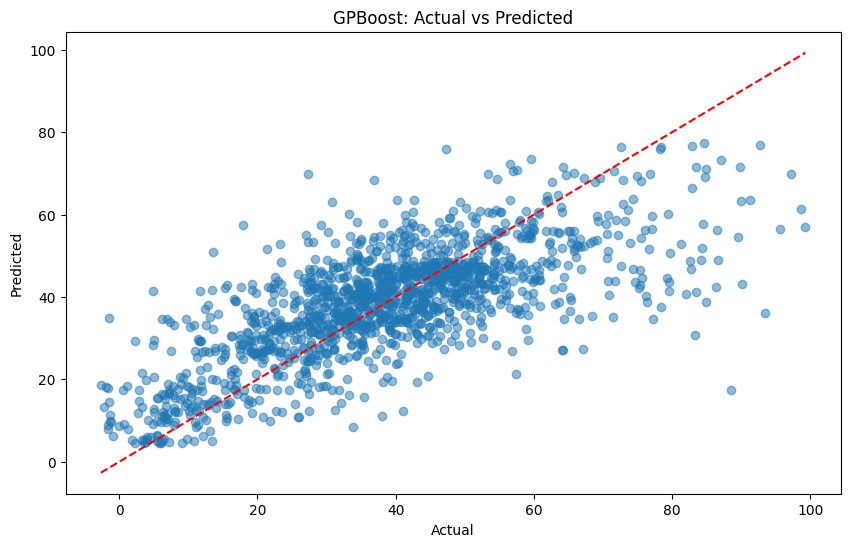


Random Effects Sample:
    Group_1  Group_1_rand_coef_nb_1  Group_1_rand_coef_nb_2  \
0  6.016979               -0.000135           -9.816122e-07   
1  6.016979               -0.000135           -9.816122e-07   
2  6.016979               -0.000135           -9.816122e-07   
3  6.016979               -0.000135           -9.816122e-07   
4  6.016979               -0.000135           -9.816122e-07   

   Group_1_rand_coef_nb_3  Group_1_rand_coef_nb_4  Group_1_rand_coef_nb_5  \
0               -0.000007               -0.000185               -0.000007   
1               -0.000007               -0.000185               -0.000007   
2               -0.000007               -0.000185               -0.000007   
3               -0.000007               -0.000185               -0.000007   
4               -0.000007               -0.000185               -0.000007   

   Group_1_rand_coef_nb_6  Group_1_rand_coef_nb_7  Group_1_rand_coef_nb_8  \
0            1.869033e-07                0.000451        

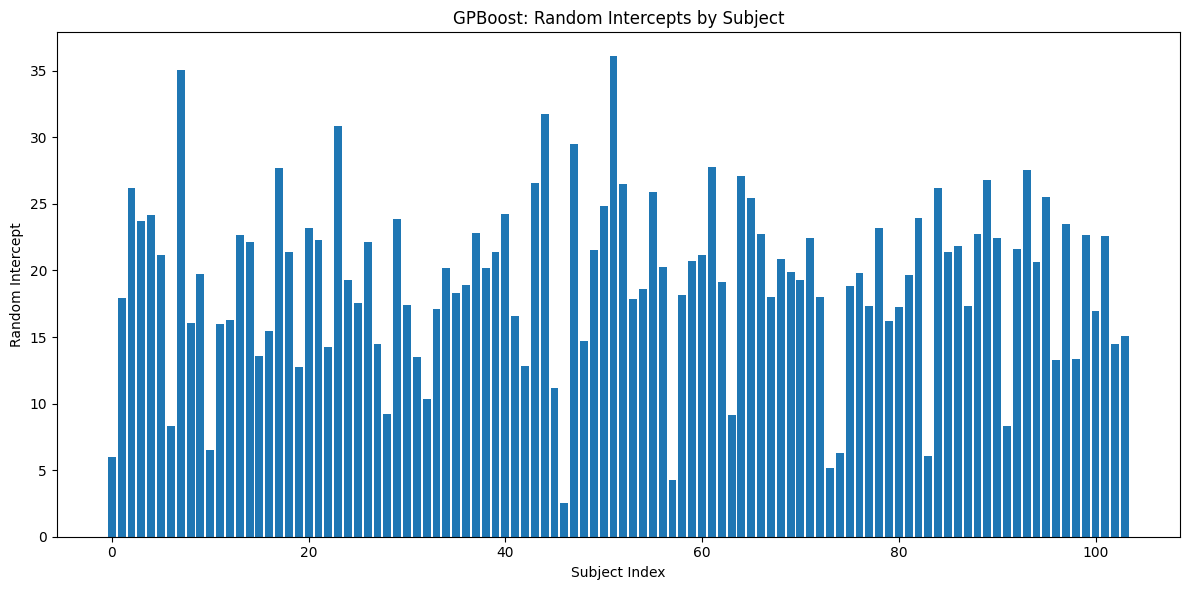

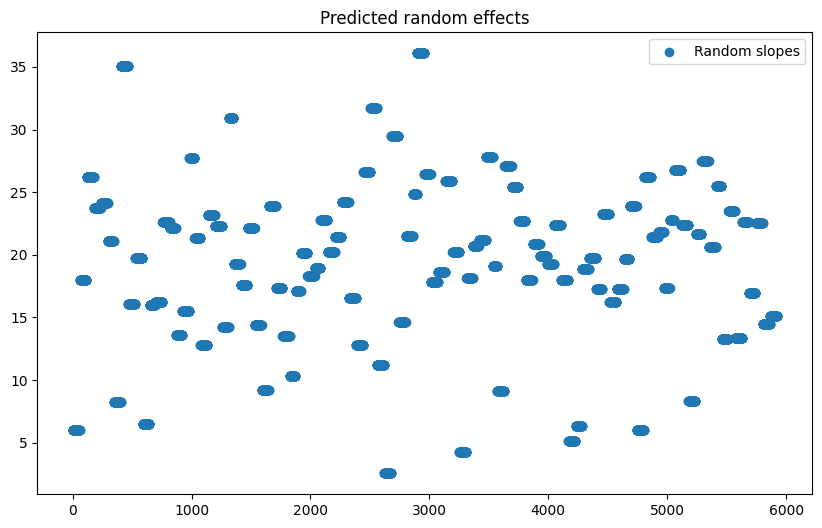

In [261]:
# Define target variable
target = 'target_wbw_gap_detrended'

# Drop rows with NaN target values
train_data_clean = train_data.dropna(subset=[target])
test_data_clean = test_data.dropna(subset=[target])

# Impute missing values in features using the provided function
train_data_imputed, test_data_imputed = impute_time_series_data(
    train_data_clean,
    test_data_clean,
    predictors=passive_1000_z2,
    subject_col='PID',  
    day_col='day',
    max_gap=7
)

# Filter features
X_train = train_data_imputed[passive_1000_z2]
X_test = test_data_imputed[passive_1000_z2]

# Add intercept column (a column of 1's) to the feature matrices
X_train_with_intercept = X_train.copy()
X_test_with_intercept = X_test.copy()
X_train_with_intercept['intercept'] = 1.0
X_test_with_intercept['intercept'] = 1.0

# Get target variable
y_train = train_data_imputed[target]
y_test = test_data_imputed[target]

# Get PID values for grouping
group_train = train_data_imputed['PID'].values
group_test = test_data_imputed['PID'].values

# Get a mapping from PID to a numeric index (needed for GPBoost)
unique_pids = np.unique(group_train)
pid_to_idx = {pid: idx for idx, pid in enumerate(unique_pids)}
group_train_idx = np.array([pid_to_idx[pid] for pid in group_train])
group_test_idx = np.array([pid_to_idx[pid] if pid in pid_to_idx else -1 for pid in group_test])

# Handle any test subjects not in training data
test_has_unknown_subjects = np.any(group_test_idx == -1)
if test_has_unknown_subjects:
    # Assign new indices to unknown subjects
    max_idx = max(pid_to_idx.values())
    for i, idx in enumerate(group_test_idx):
        if idx == -1:
            pid = group_test[i]
            max_idx += 1
            pid_to_idx[pid] = max_idx
            group_test_idx[i] = max_idx

# For random slopes, convert to numpy arrays
X_train_np = X_train_with_intercept.values
X_test_np = X_test_with_intercept.values

# Create indices for random coefficient effects
# Values should be 1 (not 0) to indicate they belong to the first random effect group
ind_effect_group_rand_coef = np.ones(X_train_np.shape[1], dtype=int)

# Initialize GPModel with random intercepts and random slopes
gp_model = gpb.GPModel(
    group_data=group_train_idx,                # Use PID indices for random intercepts
    group_rand_coef_data=X_train_np,           # For random slopes
    ind_effect_group_rand_coef=ind_effect_group_rand_coef,  # Connect random slopes to groups
    likelihood="gaussian"                      # For continuous target
)

# Set optimization parameters
params = {
    "optimizer_cov": "lbfgs",                # Optimization algorithm
    "lr_cov": 0.1,                           # Learning rate for covariance parameters
    "std_dev": True,                         # Calculate standard deviations
    "trace": True,                           # Show progress
    "use_nesterov_acc": True,                # Use Nesterov acceleration
    "init_cov_pars": None                    # Let GPBoost select initial values
}

# Fit the model
print("Fitting GPBoost model with random effects...")
gp_model.fit(y=y_train.values, params=params)

# Display model summary
print("\nModel Summary:")
gp_model.summary()

# Make predictions on test data
predictions = gp_model.predict(
    group_data_pred=group_test_idx,
    group_rand_coef_data_pred=X_test_np,
    predict_var=True                         # Include prediction variance
)

# Extract predictions
pred_mean = predictions['mu']
pred_var = predictions['var']

# Calculate metrics
mae = mean_absolute_error(y_test, pred_mean)
rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
r2 = r2_score(y_test, pred_mean)

# Print metrics
print("\nModel Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_mean, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('GPBoost: Actual vs Predicted')
plt.show()

# Get random effects and plot if desired
random_effects = gp_model.predict_training_data_random_effects(predict_var=True)
print("\nRandom Effects Sample:")
print(random_effects.head())

# Plot random intercepts by subject
unique_train_subjects = np.unique(group_train_idx)
random_intercepts = [random_effects.iloc[np.where(group_train_idx == subj)[0][0], 0] for subj in unique_train_subjects]

plt.figure(figsize=(12, 6))
plt.bar(range(len(random_intercepts)), random_intercepts)
plt.xlabel('Subject Index')
plt.ylabel('Random Intercept')
plt.title('GPBoost: Random Intercepts by Subject')
plt.tight_layout()
plt.show()
# Compare true versus predicted random slopes
plt.figure(figsize=(10, 6))
plt.scatter(range(len(random_effects)), random_effects.iloc[:, 0], label="Random slopes")
plt.legend()
plt.title("Predicted random effects")
plt.show(block=False)

## Individual Level Models

Given that we are collecting ILD we can also consider fitting models at the individual level.

This allows us to leverage the fact that individual differences mean that predictors with no meaningful group level signal may have important individual level signal.

### Example of Individual Differences: News App Usage

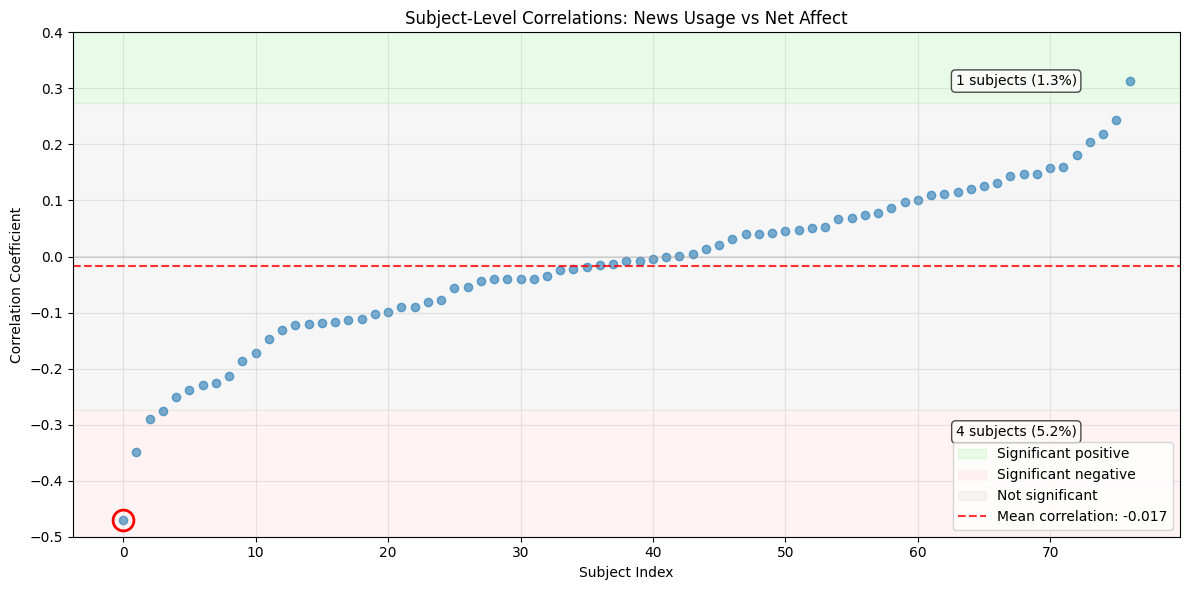

In [162]:
# Calculate correlations between news usage and net affect for each subject
correlations = []
sample_sizes = []
for pid in df['PID'].unique():
    pid_data = df[df['PID'] == pid]
    # Remove NaN values before calculating correlation
    valid_data = pid_data[['passive_sk_device_total_usage_news', 'target_net_affect_avg_detrended']].dropna()
    if len(valid_data) > 5:  # Ensure minimum sample size for correlation
        corr = valid_data['passive_sk_device_total_usage_news'].corr(valid_data['target_net_affect_avg_detrended'])
        if not pd.isna(corr):
            correlations.append((pid, corr))
            sample_sizes.append(len(valid_data))

# Convert to DataFrame and sort by correlation value
corr_df = pd.DataFrame({'PID': [c[0] for c in correlations], 
                         'correlation': [c[1] for c in correlations],
                         'sample_size': sample_sizes})
corr_df = corr_df.sort_values('correlation')

# Calculate mean correlation
mean_corr = corr_df['correlation'].mean()

# Calculate significance thresholds
alpha = 0.05  # Significance level
# Use median sample size for threshold estimation
median_n = np.median(corr_df['sample_size'])
# Formula for critical r value: r = t / sqrt(t² + df)
# where t is the critical t-value for alpha/2 and df = n-2
from scipy import stats
t_crit = stats.t.ppf(1 - alpha/2, median_n - 2)
r_crit = t_crit / np.sqrt(t_crit**2 + median_n - 2)
sig_pos = r_crit
sig_neg = -r_crit

# Create dot plot
plt.figure(figsize=(12, 6))

# Set y-axis limits explicitly to match the data range
plt.ylim(-0.5, 0.4)  # Adjusted from 1.0 to 0.4

# Add background colors for significance regions
plt.axhspan(sig_pos, 0.4, color='lightgreen', alpha=0.2, label='Significant positive')
plt.axhspan(-0.5, sig_neg, color='mistyrose', alpha=0.4, label='Significant negative')
plt.axhspan(sig_neg, sig_pos, color='lightgray', alpha=0.2, label='Not significant')

# Plot scatter points
plt.scatter(range(len(corr_df)), corr_df['correlation'], alpha=0.6)

# Find point with largest absolute correlation
max_abs_corr_idx = corr_df['correlation'].abs().idxmax()
max_abs_corr_x = corr_df.index.get_loc(max_abs_corr_idx)
max_abs_corr_y = corr_df.loc[max_abs_corr_idx, 'correlation']

# Add circle around point with largest absolute correlation
plt.plot(max_abs_corr_x, max_abs_corr_y, 'o', ms=15, mfc='none', mec='red', mew=2)

# Add mean correlation line
plt.axhline(y=mean_corr, color='red', linestyle='--', alpha=0.8,
            label=f'Mean correlation: {mean_corr:.3f}')

# Add zero line
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.2)

# Count significant correlations
n_sig_pos = sum(corr_df['correlation'] > sig_pos)
n_sig_neg = sum(corr_df['correlation'] < sig_neg)
n_not_sig = len(corr_df) - n_sig_pos - n_sig_neg

# Annotate with counts
plt.annotate(f"{n_sig_pos} subjects ({n_sig_pos/len(corr_df):.1%})", 
             xy=(len(corr_df)-5, sig_pos*1.1), 
             ha='right', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.annotate(f"{n_sig_neg} subjects ({n_sig_neg/len(corr_df):.1%})", 
             xy=(len(corr_df)-5, sig_neg*1.1), 
             ha='right', va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.title('Subject-Level Correlations: News Usage vs Net Affect')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Subject Index')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

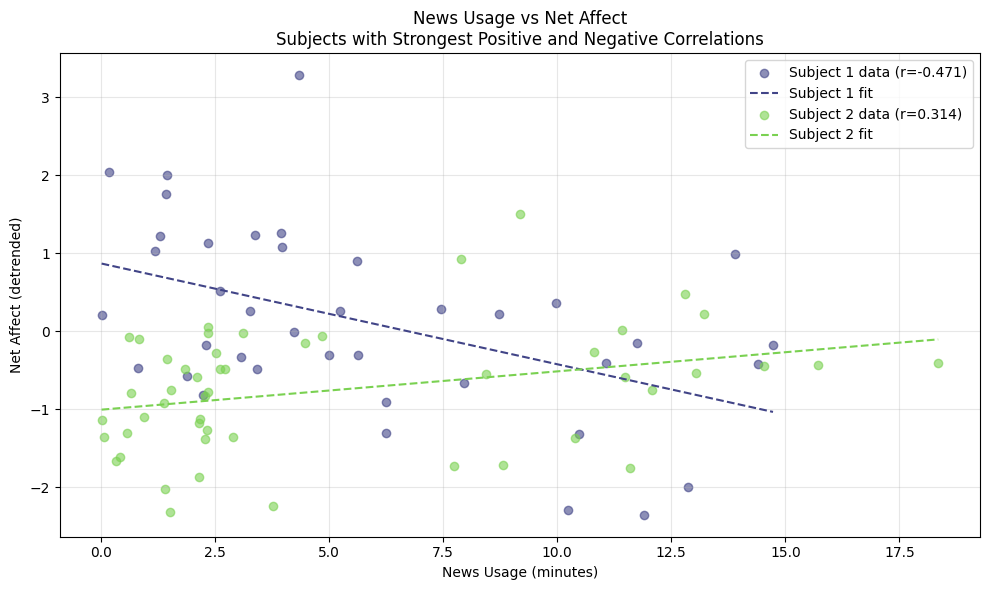

In [163]:
# Find PIDs with largest positive and negative correlations
strongest_neg_idx = corr_df['correlation'].idxmin()
strongest_pos_idx = corr_df['correlation'].idxmax()

strongest_neg_pid = corr_df.loc[strongest_neg_idx, 'PID']
strongest_pos_pid = corr_df.loc[strongest_pos_idx, 'PID']
strongest_neg_corr = corr_df.loc[strongest_neg_idx, 'correlation']
strongest_pos_corr = corr_df.loc[strongest_pos_idx, 'correlation']

# Get two distinct colors from viridis
colors = plt.cm.viridis([0.2, 0.8])  # Two well-separated points in the colormap

# Create figure
plt.figure(figsize=(10, 6))

# Plot data for subject with strongest negative correlation
neg_subject_data = df[df['PID'] == strongest_neg_pid]
neg_valid_data = neg_subject_data[['passive_sk_device_total_usage_news', 'target_net_affect_avg_detrended']].dropna()

X_raw_neg = neg_valid_data['passive_sk_device_total_usage_news'].values
adjustment_neg = 1 - X_raw_neg.min()
X_neg = (X_raw_neg + adjustment_neg).reshape(-1, 1)
y_neg = neg_valid_data['target_net_affect_avg_detrended'].values

# Fit linear model for negative correlation
model_neg = LinearRegression()
model_neg.fit(X_neg, y_neg)

# Create prediction line for negative correlation
X_line_neg = np.linspace(X_neg.min(), X_neg.max(), 100).reshape(-1, 1)
y_pred_neg = model_neg.predict(X_line_neg)

# Plot negative correlation data
plt.scatter(X_neg/60, y_neg, alpha=0.6, color=colors[0], label=f'Subject 1 data (r={strongest_neg_corr:.3f})')
plt.plot(X_line_neg/60, y_pred_neg, '--', color=colors[0], label=f'Subject 1 fit')

# Plot data for subject with strongest positive correlation
pos_subject_data = df[df['PID'] == strongest_pos_pid]
pos_valid_data = pos_subject_data[['passive_sk_device_total_usage_news', 'target_net_affect_avg_detrended']].dropna()

X_raw_pos = pos_valid_data['passive_sk_device_total_usage_news'].values
adjustment_pos = 1 - X_raw_pos.min()
X_pos = (X_raw_pos + adjustment_pos).reshape(-1, 1)
y_pos = pos_valid_data['target_net_affect_avg_detrended'].values

# Fit linear model for positive correlation
model_pos = LinearRegression()
model_pos.fit(X_pos, y_pos)

# Create prediction line for positive correlation
X_line_pos = np.linspace(X_pos.min(), X_pos.max(), 100).reshape(-1, 1)
y_pred_pos = model_pos.predict(X_line_pos)

# Plot positive correlation data
plt.scatter(X_pos/60, y_pos, alpha=0.6, color=colors[1], label=f'Subject 2 data (r={strongest_pos_corr:.3f})')
plt.plot(X_line_pos/60, y_pred_pos, '--', color=colors[1], label=f'Subject 2 fit')

plt.title('News Usage vs Net Affect\nSubjects with Strongest Positive and Negative Correlations')
plt.xlabel('News Usage (minutes)')
plt.ylabel('Net Affect (detrended)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Linear Regression

In [185]:
# Get list of passive features
passive_features = [col for col in df.columns if col.startswith('passive_')]

<div style="
    background-color:rgb(190, 240, 255);
    border-left: solid 4pxrgb(247, 117, 117);
    border-radius: 4px;
    margin: 10px 0;
    padding: 15px;
    font-family: sans-serif;
">
    <p style="margin: 0; color: #2c3e50;">
        <strong>INFO</strong><br> <br>
        There are many more features in <code>passive_cols</code> than in <code>passive_features</code>.
        <br> <br>
        This is because <code>passive_cols</code> includes all feature engineering features, which are not included in <code>passive_features</code>. 
        <br> <br>
        These columns all start with <code>fe_</code>.
    </p>
</div>


In [187]:
# Print lengths
print(f"Number of passive_features: {len(passive_features)}")
print(f"Number of passive_cols: {len(passive_cols)}")

Number of passive_features: 83
Number of passive_cols: 664


In [ ]:
# Function to build best n-dimensional model for each subject
def build_subject_models(data, target, n_dimensions=2):
    """
    Build best n-dimensional linear models for each subject using passive features.
    
    Parameters:
    -----------
    data : DataFrame
        Full dataset containing all subjects
    target : str
        Name of the target column
    n_dimensions : int
        Number of features to use in each subject's model
        
    Returns:
    --------
    DataFrame with results for each subject
    """
    results = []
    
    # For each PID in the data
    for pid in data['PID'].unique():
        try:
            # Get subject data
            subject_data = data[data['PID'] == pid].dropna(subset=[target]).sort_values('day')
            
            # Skip if not enough data
            if len(subject_data) < 10:  # Minimum 10 data points
                continue
                
            # Split data into first 50% for feature selection and remainder for modeling
            split_day = subject_data['day'].quantile(0.5)
            feature_selection_data = subject_data[subject_data['day'] <= split_day]
            modeling_data = subject_data  # Keep all data for modeling
            
            # Record last day used for correlation calculation
            last_day_correlation = feature_selection_data['day'].max()
            
            # Calculate correlations between passive features and target
            correlations = {}
            for feature in passive_features:
                if feature in feature_selection_data.columns:
                    # Skip features with too many NaN values (e.g., >50%)
                    nan_ratio = feature_selection_data[feature].isna().mean()
                    if nan_ratio > 0.5:
                        continue
                        
                    # Calculate correlation, ignoring NaN values
                    correlation = feature_selection_data[feature].corr(feature_selection_data[target])
                    if not pd.isna(correlation):
                        correlations[feature] = abs(correlation)
            
            if len(correlations) < n_dimensions:
                continue
                
            # Get top n features with highest correlation
            top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:n_dimensions]
            top_feature_names = [feature for feature, corr in top_features]
            
            # Create X and y, dropping rows with NaNs
            features_plus_target = top_feature_names + [target]
            filtered_data = modeling_data[features_plus_target + ['day']].dropna()
            
            # Skip if not enough data after dropping NaNs
            if len(filtered_data) < n_dimensions + 5:  # Need more than just the parameters
                continue
            
            # Do train-test split (80/20)
            train_size = int(0.8 * len(filtered_data))
            train_data = filtered_data.iloc[:train_size]
            test_data = filtered_data.iloc[train_size:]
            
            # Skip if test set is too small
            if len(test_data) < 2:
                continue
                
            # Record first day in test data
            first_day_test = test_data['day'].min() if 'day' in test_data.columns else None
            
            # Store days for training and test data
            train_days = train_data['day'].tolist() if 'day' in train_data.columns else []
            test_days = test_data['day'].tolist() if 'day' in test_data.columns else []
            
            # Check for potential data leakage
            leakage_flag = 1 if last_day_correlation > first_day_test else 0
            
            # Normalize features using training data statistics
            X_train = train_data[top_feature_names].copy()
            X_test = test_data[top_feature_names].copy()
            
            # Calculate mean and std for each feature from training data
            feature_stats = {}
            for feature in top_feature_names:
                feature_stats[feature] = {
                    'mean': X_train[feature].mean(),
                    'std': X_train[feature].std()
                }
                
                # Avoid division by zero
                if feature_stats[feature]['std'] == 0:
                    feature_stats[feature]['std'] = 1
                
                # Normalize
                X_train[feature] = (X_train[feature] - feature_stats[feature]['mean']) / feature_stats[feature]['std']
                X_test[feature] = (X_test[feature] - feature_stats[feature]['mean']) / feature_stats[feature]['std']
            
            y_train = train_data[target].values
            y_test = test_data[target].values
            
            # Fit linear model on training data
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate metrics
            train_r2 = r2_score(y_train, y_train_pred) if len(y_train) > 1 else np.nan
            test_r2 = r2_score(y_test, y_test_pred) if len(y_test) > 1 else np.nan
            
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            # Calculate mean metrics
            train_mean_error = (train_mae + train_rmse) / 2
            test_mean_error = (test_mae + test_rmse) / 2
            mean_error_mean = (train_mean_error + test_mean_error) / 2
            mean_error_diff = abs(train_mean_error - test_mean_error)
            
            # Calculate mean R²
            mean_r2 = np.nanmean([train_r2, test_r2]) if not (np.isnan(train_r2) or np.isnan(test_r2)) else np.nan
            
            # New metric 1: Median prediction accuracy
            target_median = np.median(y_train)
            train_median_acc = np.mean(((y_train > target_median) == (y_train_pred > target_median)).astype(int))
            test_median_acc = np.mean(((y_test > target_median) == (y_test_pred > target_median)).astype(int))
            
            # New metric 2: Daily change accuracy
            # For training data
            train_actual_changes = np.diff(y_train)
            train_pred_changes = np.diff(y_train_pred)
            train_change_acc = np.mean((np.sign(train_actual_changes) == np.sign(train_pred_changes)).astype(int)) if len(train_actual_changes) > 0 else np.nan
            
            # For test data
            test_actual_changes = np.diff(y_test)
            test_pred_changes = np.diff(y_test_pred)
            test_change_acc = np.mean((np.sign(test_actual_changes) == np.sign(test_pred_changes)).astype(int)) if len(test_actual_changes) > 0 else np.nan
            
            # Store each feature in a separate element
            feature_names_list = []
            feature_coefs_list = []
            feature_corrs_list = []
            
            for i, (feature, corr) in enumerate(top_features):
                coef = model.coef_[i] if len(top_feature_names) > 1 else model.coef_[0]
                feature_names_list.append(feature)
                feature_coefs_list.append(coef)
                feature_corrs_list.append(corr)
            
            # Create the old feature string for backward compatibility
            feature_info = []
            for feature, coef, corr in zip(feature_names_list, feature_coefs_list, feature_corrs_list):
                feature_info.append(f"{feature} (coef: {coef:.3f}, corr: {corr:.3f})")
            feature_str = ", ".join(feature_info)
            
            results.append({
                'PID': pid,
                'features': feature_str,  # Keep the old format for backward compatibility
                'feature_names': feature_names_list,  # New: list of feature names
                'feature_coefs': feature_coefs_list,  # New: list of coefficients
                'feature_corrs': feature_corrs_list,  # New: list of correlations
                'n_features': n_dimensions,
                'last_day_correlation': last_day_correlation,
                'first_day_test': first_day_test,
                'train_days': train_days,  # New: list of training days
                'test_days': test_days,    # New: list of test days
                'leakage_flag': leakage_flag,  # New: flag for potential data leakage
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mean_error': train_mean_error,
                'test_mean_error': test_mean_error,
                'mean_error_mean': mean_error_mean,
                'mean_error_diff': mean_error_diff,
                'mean_r2': mean_r2,
                'train_median_acc': train_median_acc,  # New: median prediction accuracy (train)
                'test_median_acc': test_median_acc,    # New: median prediction accuracy (test)
                'train_change_acc': train_change_acc,  # New: daily change accuracy (train)
                'test_change_acc': test_change_acc,    # New: daily change accuracy (test)
                'train_samples': len(train_data),
                'test_samples': len(test_data)
            })
        except Exception as e:
            print(f"Error processing PID {pid}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

# Set target variable
target = 'target_wbw_gap_detrended'  # or 'target_net_affect_avg_detrended'

# Try with different dimensions
dimensions_to_test = [1, 2, 3, 5]
all_results = []

for n_dim in dimensions_to_test:
    print(f"Building {n_dim}-dimensional models for all subjects...")
    dim_results = build_subject_models(df, target=target, n_dimensions=n_dim)
    dim_results['model_size'] = n_dim  # Add column indicating model size
    all_results.append(dim_results)

# Combine all results
results_df = pd.concat(all_results)
# Sort by test R² (descending)
results_df.sort_values('test_r2', ascending=False, inplace=True)

# Display summary by model size
print("\nSummary of model performance by dimension:")
summary = results_df.groupby('model_size').agg({
    'train_r2': ['mean', 'max'],
    'test_r2': ['mean', 'max'],
    'train_mae': ['mean', 'min'],
    'test_mae': ['mean', 'min'],
    'train_rmse': ['mean', 'min'],
    'test_rmse': ['mean', 'min'],
    'train_median_acc': ['mean', 'max'],  # New metrics in summary
    'test_median_acc': ['mean', 'max'],
    'train_change_acc': ['mean', 'max'],
    'test_change_acc': ['mean', 'max'],
    'leakage_flag': ['sum', 'mean'],
    'PID': 'count'
}).reset_index()

print(summary)

Building 1-dimensional models for all subjects...
Building 2-dimensional models for all subjects...
Building 3-dimensional models for all subjects...
Building 5-dimensional models for all subjects...

Summary of model performance by dimension:
  model_size  train_r2              test_r2           train_mae            \
                  mean       max       mean       max      mean       min   
0          1  0.160148  0.462176  -1.405411  0.539022  9.640428  2.943357   
1          2  0.265535  0.784663 -19.994799  0.624517  8.886002  2.462448   
2          3  0.320921  0.904718  -2.284331  0.535847  8.469871  2.471064   
3          5  0.401085  0.983077  -9.328753  0.707300  7.879804  0.765986   

    test_mae           train_rmse  ... train_median_acc test_median_acc       \
        mean       min       mean  ...              max            mean  max   
0  11.109403  2.886077  12.150348  ...         0.826087        0.526972  1.0   
1  13.169088  2.906951  11.193984  ...         0.9090


Filters applied:
- Minimum training days: 25
- Excluding flagged models: True
- One model per subject: True
- Sorting by: mean_r2 (ascending=False)
- Number of models after filtering: 91
- Showing top 5 models


,PID,feature_names,n_features,train_samples,test_samples,train_r2,test_r2,train_mae,test_mae,leakage_flag
14,156895d9-0f71-4844-92dd-3fb298f84f2b,"[passive_hk_activity_activeEnergyBurned, passi...",5,28,7,0.614187,0.522656,11.733473,9.317537,0
2,0501ba67-3406-4779-aff1-878a0e9f7885,"[passive_sk_visits_home_elapsed, passive_sk_vi...",5,28,7,0.722045,0.157688,9.945268,14.132924,0
32,42d753dd-c35f-42a6-8e3c-8d7e2f52a31a,"[passive_sk_device_total_usage_entertainment, ...",3,31,8,0.410003,0.433309,12.187887,6.800848,0
86,d5f19109-8219-40e6-9fc1-6e02c3a06dcd,"[passive_hk_activity_averageWalkingSpeed, pass...",3,27,7,0.464736,0.281899,9.488509,6.616362,0
27,39efadc3-7957-4b75-b560-d0d6c89cfe8b,"[passive_sk_visits_home_elapsed, passive_sk_de...",2,37,10,0.376767,0.325557,13.148799,16.169225,0



Plotting model for subject 156895d9-0f71-4844-92dd-3fb298f84f2b with features: ['passive_hk_activity_activeEnergyBurned', 'passive_sk_visits_unknown_elapsed', 'passive_sk_device_total_usage_health_and_fitness', 'passive_hk_activity_steps', 'passive_hk_activity_distanceWalkingRunning']


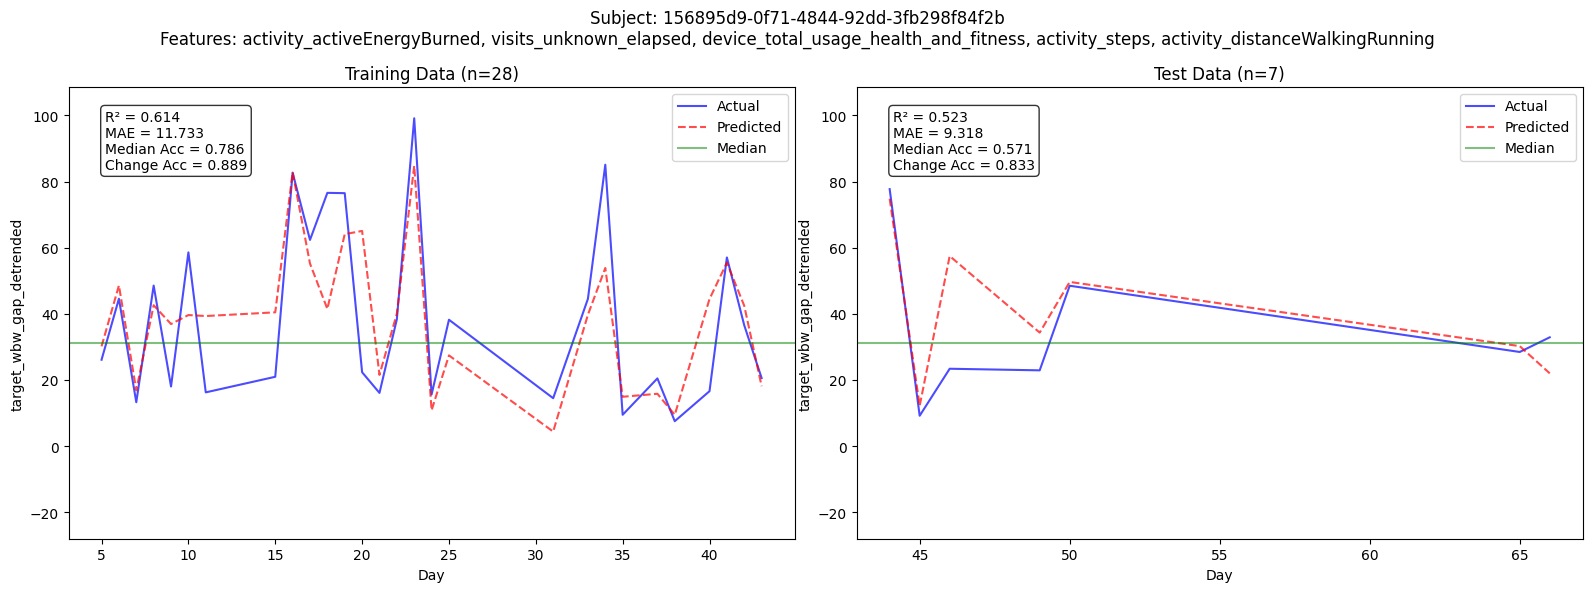

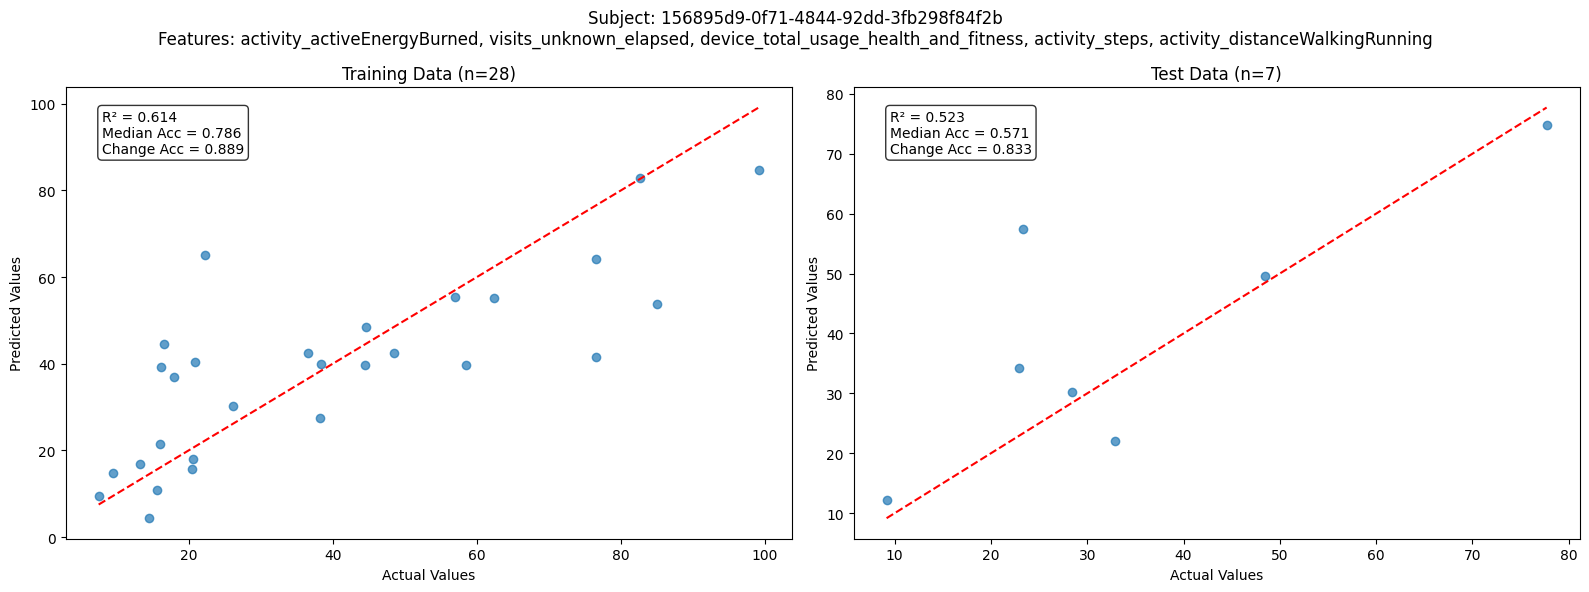


Plotting model for subject 0501ba67-3406-4779-aff1-878a0e9f7885 with features: ['passive_sk_visits_home_elapsed', 'passive_sk_visits_work_elapsed', 'passive_sk_messages_inOut_ratio', 'passive_sk_messages_incoming', 'passive_sk_keyboard_sentiment_combined_positive']


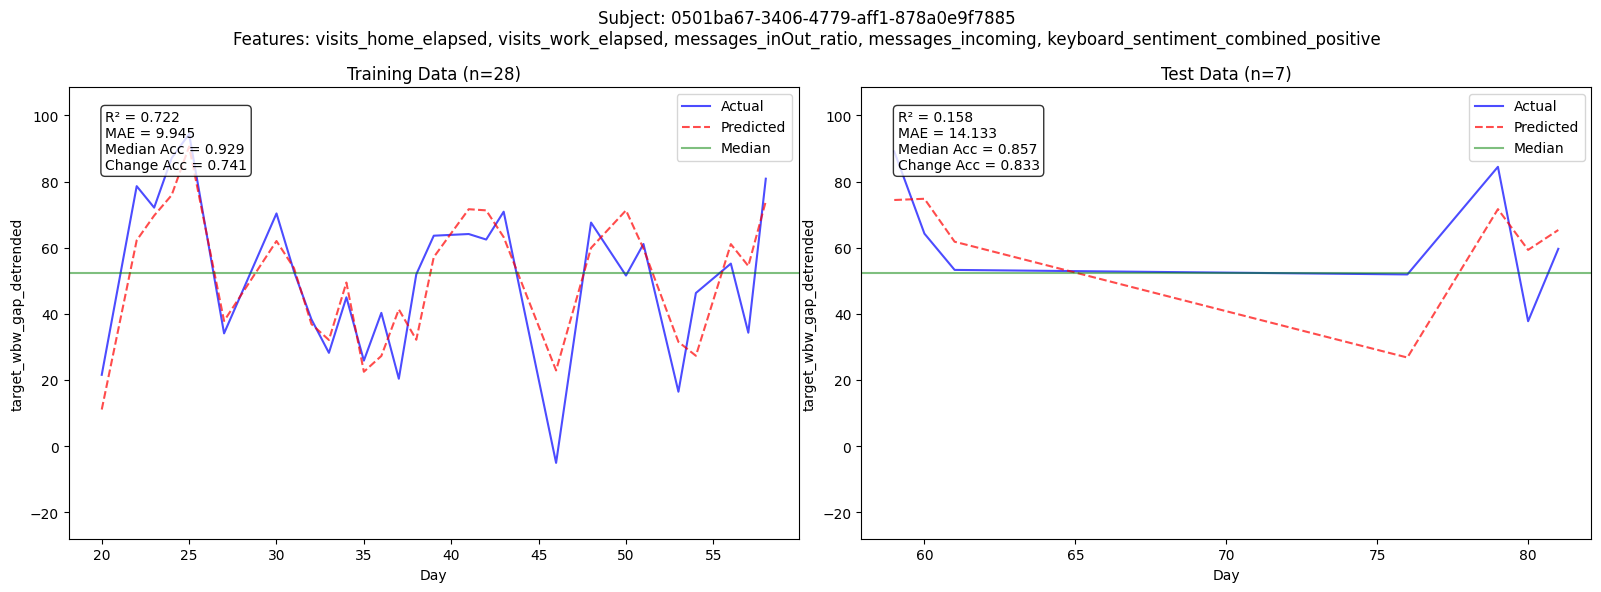

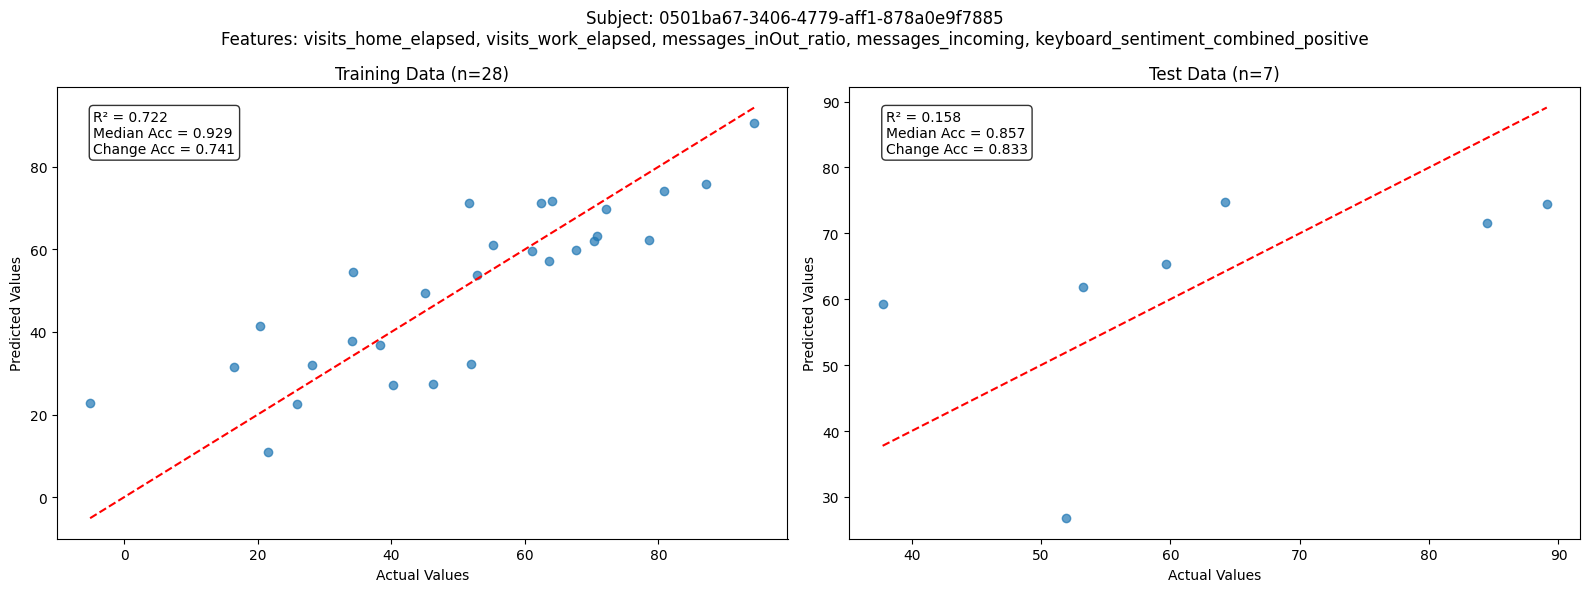


Plotting model for subject 42d753dd-c35f-42a6-8e3c-8d7e2f52a31a with features: ['passive_sk_device_total_usage_entertainment', 'passive_sk_device_total_unlock_duration', 'passive_sk_device_total_usage_finance']


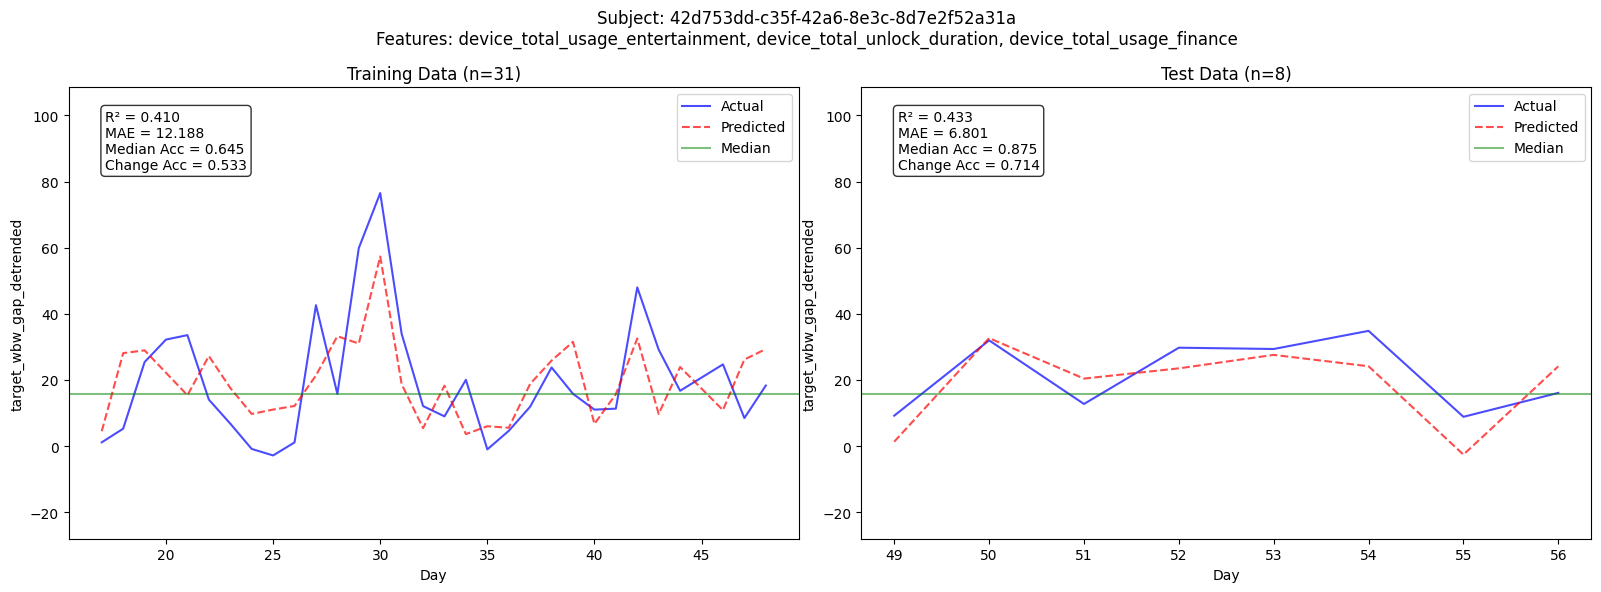

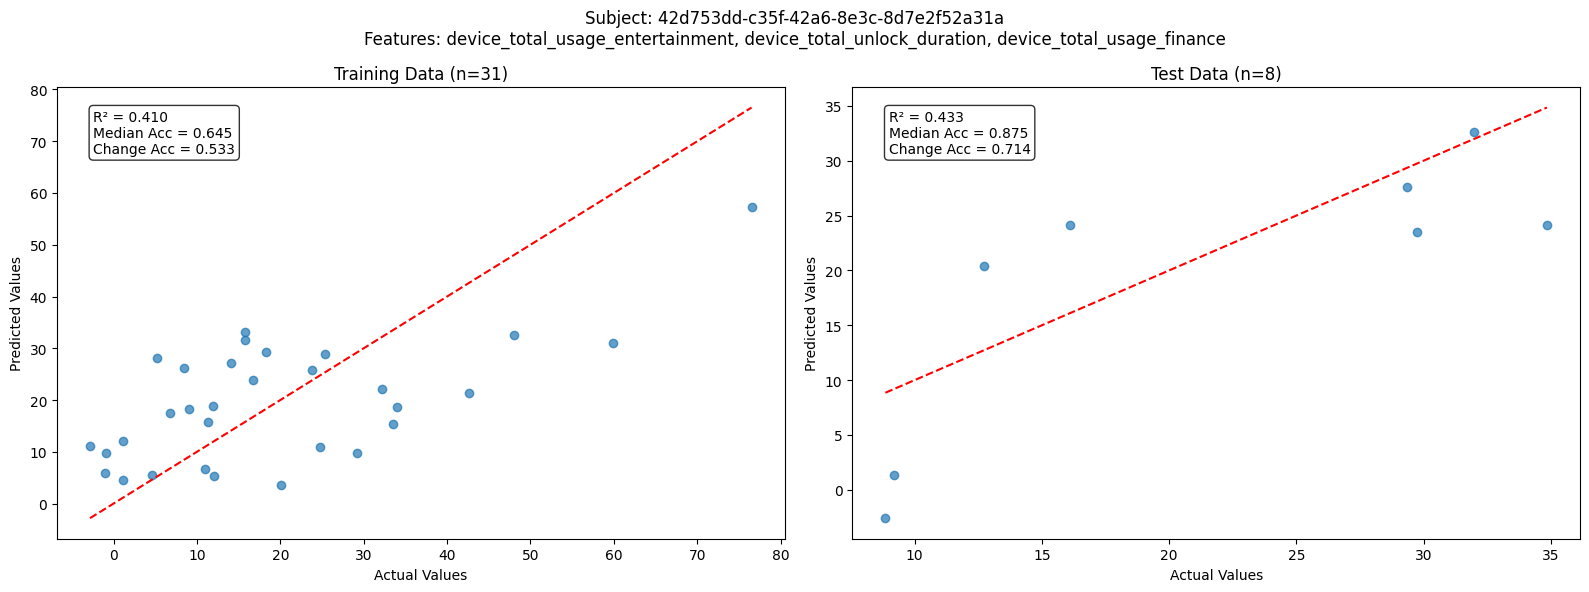


Plotting model for subject d5f19109-8219-40e6-9fc1-6e02c3a06dcd with features: ['passive_hk_activity_averageWalkingSpeed', 'passive_sk_device_total_usage_health_and_fitness', 'passive_sk_keyboard_sentiment_combined_health']


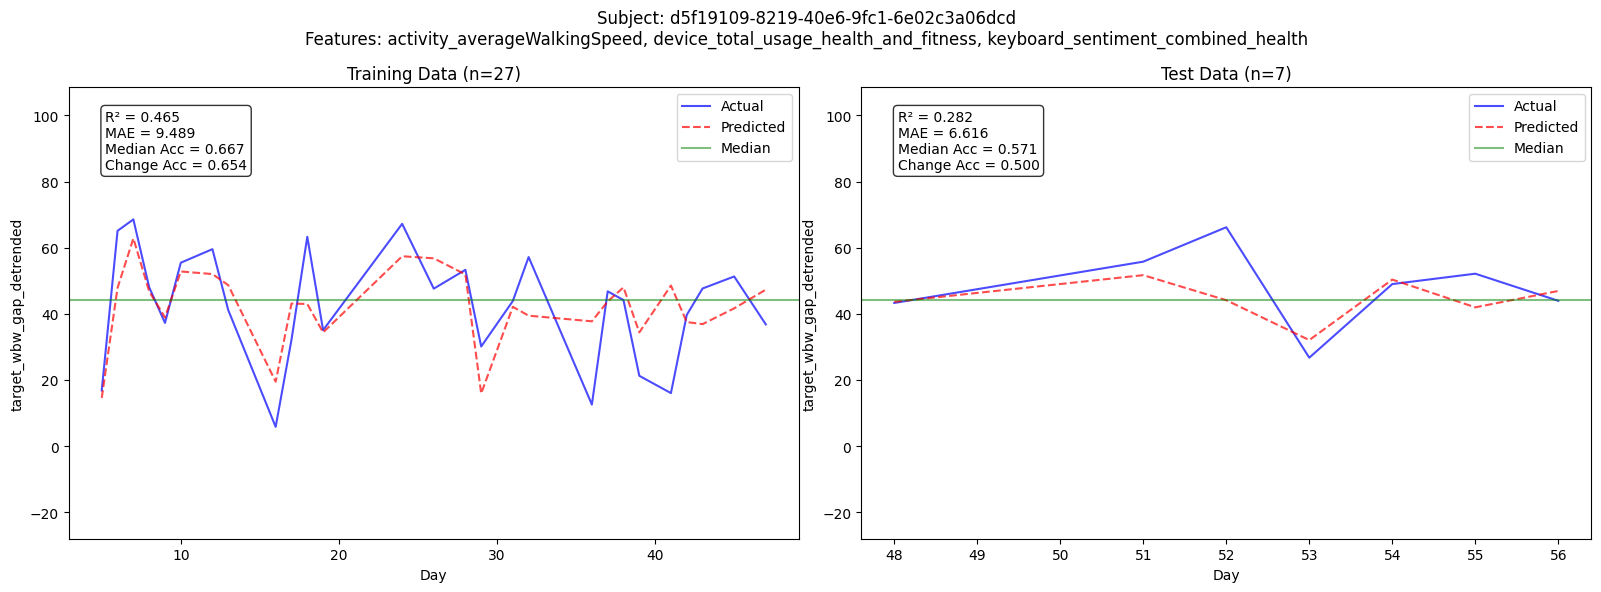

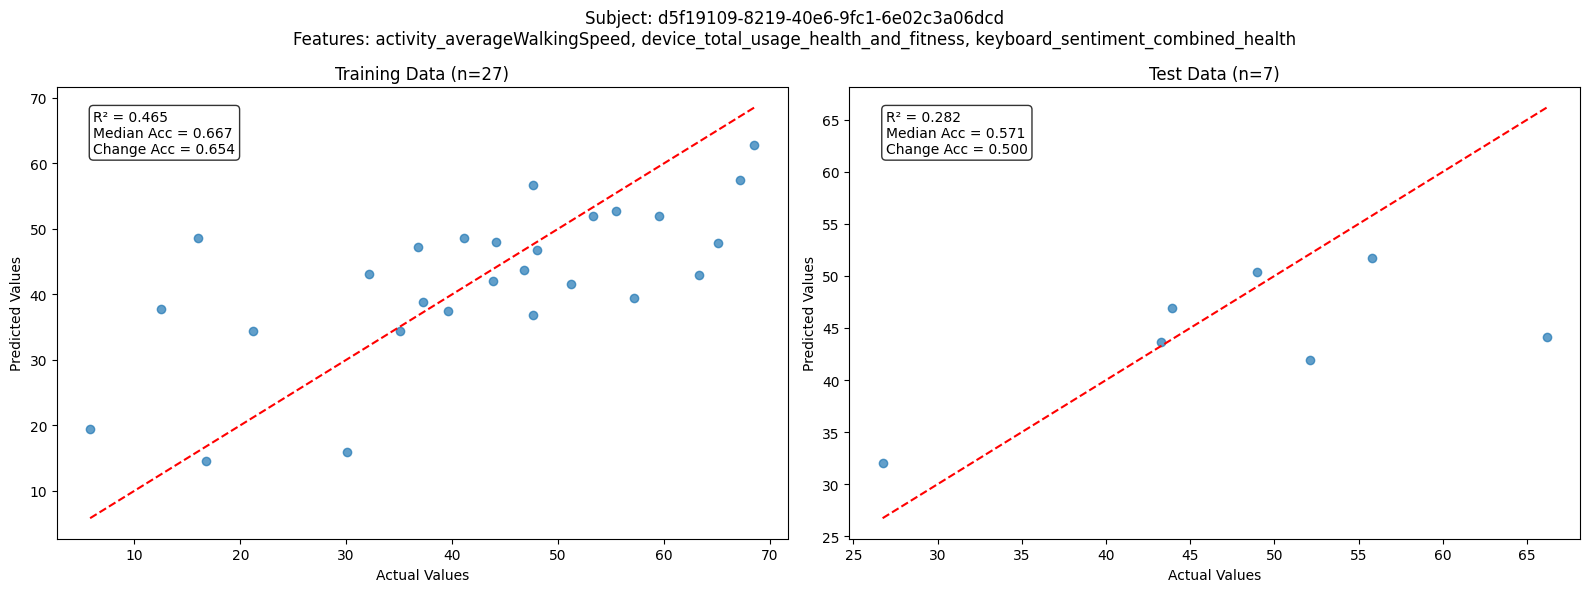


Plotting model for subject 39efadc3-7957-4b75-b560-d0d6c89cfe8b with features: ['passive_sk_visits_home_elapsed', 'passive_sk_device_total_usage_health_and_fitness']


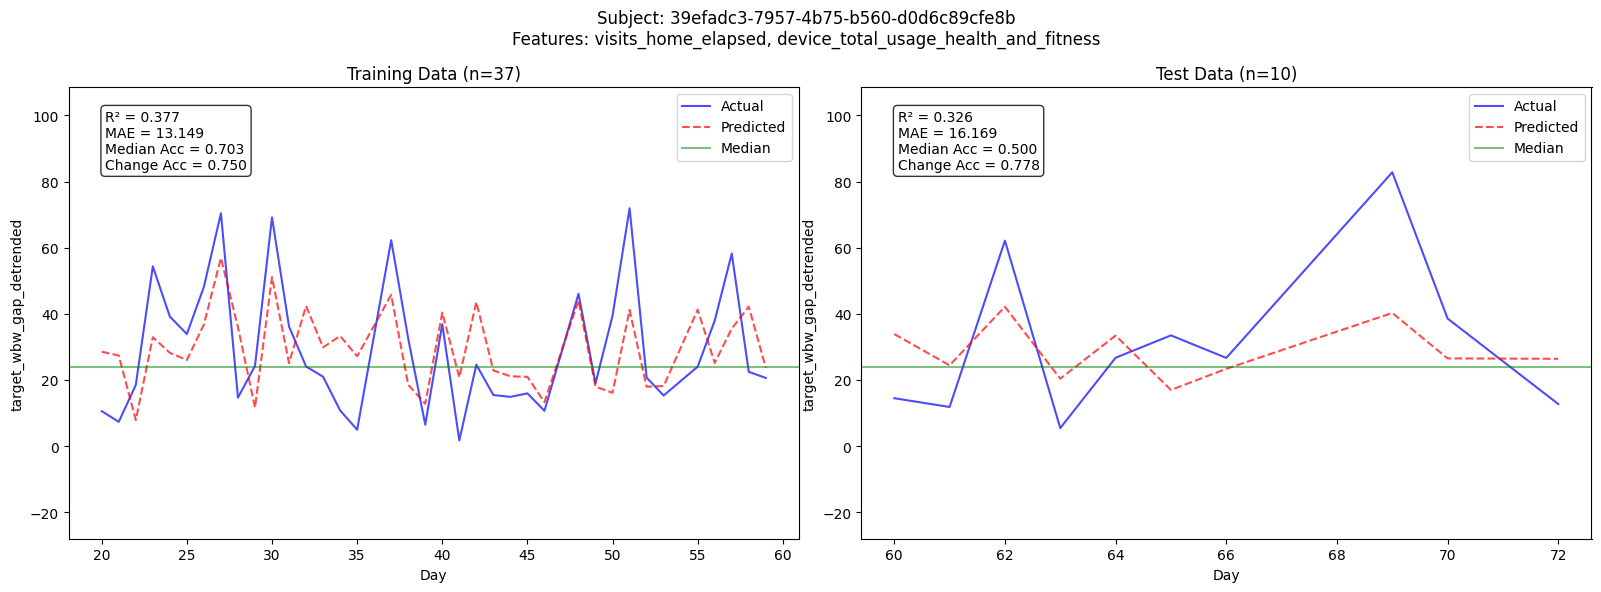

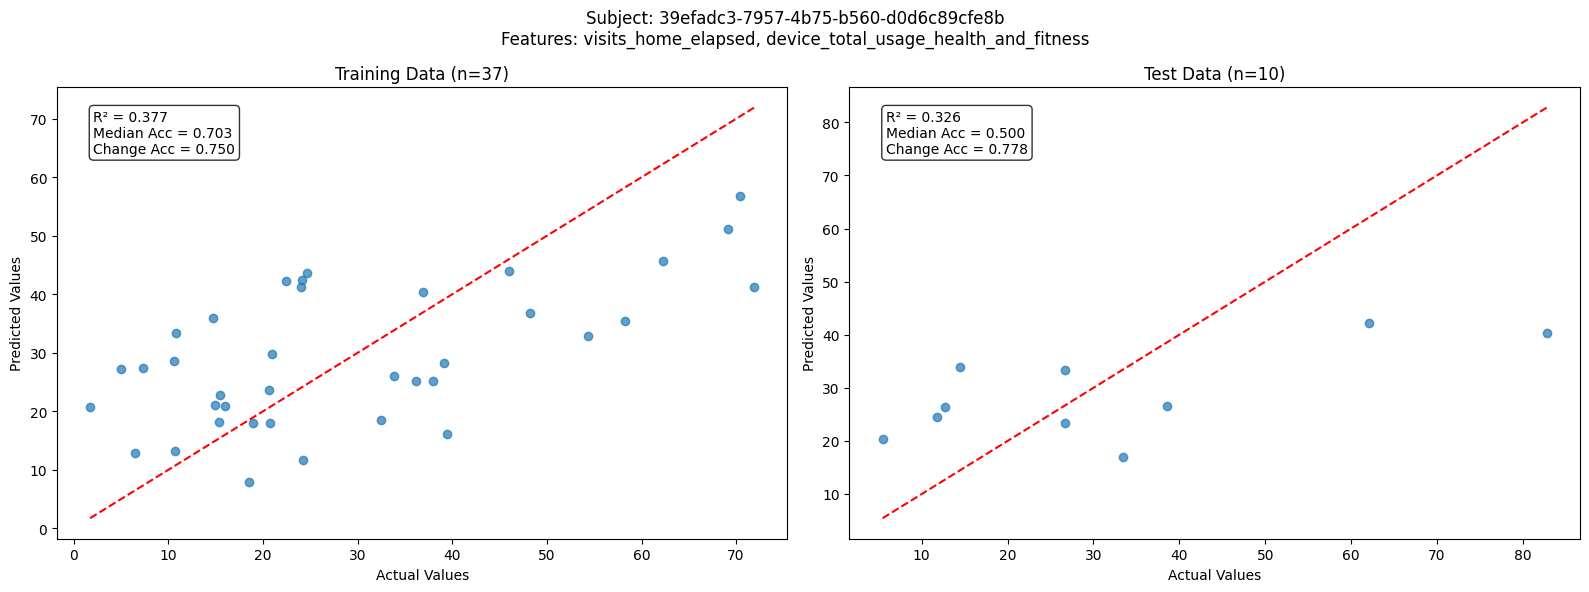

In [ ]:
def plot_subject_model(pid, row, df, target):
    """
    Plot actual vs predicted values for a subject model.
    
    Parameters:
    -----------
    pid : str
        Subject identifier
    row : Series
        Row from results_df containing model information
    df : DataFrame
        Full dataset containing all subjects
    target : str
        Name of the target column
    """
    # Get feature names directly from the row
    feature_names = row['feature_names']
    
    # Get subject data
    subject_data = df[df['PID'] == pid].dropna(subset=[target]).sort_values('day')
    
    # Create X and y, dropping rows with NaNs
    features_plus_target = feature_names + [target]
    filtered_data = subject_data[features_plus_target + ['day']].dropna()
    
    # Do train-test split (80/20)
    train_size = int(0.8 * len(filtered_data))
    train_data = filtered_data.iloc[:train_size]
    test_data = filtered_data.iloc[train_size:]
    
    # Normalize features using training data statistics
    X_train = train_data[feature_names].copy()
    X_test = test_data[feature_names].copy()
    
    # Calculate mean and std for each feature from training data
    for feature in feature_names:
        # Get stats from training data
        mean_val = X_train[feature].mean()
        std_val = X_train[feature].std()
        
        # Avoid division by zero
        if std_val == 0:
            std_val = 1
        
        # Normalize
        X_train[feature] = (X_train[feature] - mean_val) / std_val
        X_test[feature] = (X_test[feature] - mean_val) / std_val
    
    y_train = train_data[target].values
    y_test = test_data[target].values
    
    # Calculate the median of the target for this subject
    target_median = np.median(filtered_data[target])
    
    # Fit linear model on training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Calculate new metrics
    # Median prediction accuracy
    target_median = np.median(y_train)
    train_median_acc = np.mean(((y_train > target_median) == (y_train_pred > target_median)).astype(int))
    test_median_acc = np.mean(((y_test > target_median) == (y_test_pred > target_median)).astype(int))
    
    # Daily change accuracy
    train_actual_changes = np.diff(y_train)
    train_pred_changes = np.diff(y_train_pred)
    train_change_acc = np.mean((np.sign(train_actual_changes) == np.sign(train_pred_changes)).astype(int)) if len(train_actual_changes) > 0 else np.nan
    
    test_actual_changes = np.diff(y_test)
    test_pred_changes = np.diff(y_test_pred)
    test_change_acc = np.mean((np.sign(test_actual_changes) == np.sign(test_pred_changes)).astype(int)) if len(test_actual_changes) > 0 else np.nan
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot time series
    train_days = train_data['day'].values
    test_days = test_data['day'].values
    
    # Training data plot
    ax1.plot(train_days, y_train, 'b-', label='Actual', alpha=0.7)
    ax1.plot(train_days, y_train_pred, 'r--', label='Predicted', alpha=0.7)
    ax1.axhline(y=target_median, color='g', linestyle='-', alpha=0.5, label='Median')
    ax1.set_xlabel('Day')
    ax1.set_ylabel(target)
    ax1.set_title(f'Training Data (n={len(y_train)})')
    ax1.legend()
    
    # Test data plot
    ax2.plot(test_days, y_test, 'b-', label='Actual', alpha=0.7)
    ax2.plot(test_days, y_test_pred, 'r--', label='Predicted', alpha=0.7)
    ax2.axhline(y=target_median, color='g', linestyle='-', alpha=0.5, label='Median')
    ax2.set_xlabel('Day')
    ax2.set_ylabel(target)
    ax2.set_title(f'Test Data (n={len(y_test)})')
    ax2.legend()
    
    # Add metrics annotations with new metrics
    ax1.annotate(f'R² = {train_r2:.3f}\nMAE = {train_mae:.3f}\nMedian Acc = {train_median_acc:.3f}\nChange Acc = {train_change_acc:.3f}', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                va='top')
    
    ax2.annotate(f'R² = {test_r2:.3f}\nMAE = {test_mae:.3f}\nMedian Acc = {test_median_acc:.3f}\nChange Acc = {test_change_acc:.3f}', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                va='top')
    
    # Clean feature names by removing prefixes
    clean_feature_names = []
    for feat in feature_names:
        if feat.startswith('passive_sk_'):
            clean_feature_names.append(feat.replace('passive_sk_', ''))
        elif feat.startswith('passive_hk_'):
            clean_feature_names.append(feat.replace('passive_hk_', ''))
        else:
            clean_feature_names.append(feat)
    
    # Join all features on a single line without coefficient/correlation info
    feature_str = ', '.join(clean_feature_names)
    
    # Add leakage information if flag is present
    leakage_info = ""
    if 'leakage_flag' in row and row['leakage_flag'] == 1:
        leakage_info = " - POTENTIAL DATA LEAKAGE DETECTED"
    
    # Put all features on one line in the suptitle
    plt.suptitle(f'Subject: {pid}{leakage_info}\nFeatures: {feature_str}', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust top margin for title
    
    return fig, train_days, test_days, y_train, y_train_pred, y_test, y_test_pred, train_median_acc, test_median_acc, train_change_acc, test_change_acc

def plot_top_subject_models(results_df, df, target, num_subs=10, min_train_days=25, 
                           exclude_flagged=True, one_model_per_subject=True, 
                           sort_by='test_r2'):
    """
    Plot the top performing subject models with various filtering options.
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing model results
    df : DataFrame
        Full dataset containing all subjects
    target : str
        Name of the target column
    num_subs : int
        Number of subjects to plot
    min_train_days : int
        Minimum number of training days required
    exclude_flagged : bool
        Whether to exclude models with potential data leakage
    one_model_per_subject : bool
        Whether to include only one model per subject
    sort_by : str
        Metric to sort by (e.g., 'test_r2', 'test_mae', 'mean_error')
    """
    # Make a copy to avoid modifying the original
    filtered_results = results_df.copy()
    
    # Apply minimum training days filter
    filtered_results = filtered_results[filtered_results['train_samples'] >= min_train_days]
    
    # Apply flag filter if requested
    if exclude_flagged:
        filtered_results = filtered_results[filtered_results['leakage_flag'] != 1]
    
    # Determine sorting order (ascending for error metrics, descending for accuracy metrics)
    ascending = True if sort_by in ['test_mae', 'train_mae', 'test_rmse', 'train_rmse', 'mean_error', 'mean_error_diff', 'test_mean_error', 'train_mean_error'] else False
    
    # Sort by the selected metric
    filtered_results = filtered_results.sort_values(by=sort_by, ascending=ascending)
    
    # Keep only one model per subject if requested
    if one_model_per_subject:
        filtered_results = filtered_results.drop_duplicates(subset=['PID'])
    
    # Get top N subjects after all filtering
    top_subjects = filtered_results.head(num_subs)
    
    # Print summary of filters applied
    print(f"\nFilters applied:")
    print(f"- Minimum training days: {min_train_days}")
    print(f"- Excluding flagged models: {exclude_flagged}")
    print(f"- One model per subject: {one_model_per_subject}")
    print(f"- Sorting by: {sort_by} (ascending={ascending})")
    print(f"- Number of models after filtering: {len(filtered_results)}")
    print(f"- Showing top {min(num_subs, len(top_subjects))} models")
    
    # Display top subjects
    display(top_subjects[['PID', 'feature_names', 'n_features', 'train_samples', 'test_samples', 
                          'train_r2', 'test_r2', 'train_mae', 'test_mae', 'leakage_flag']])
    
    # Calculate global min and max for the target
    global_min = df[target].min()
    global_max = df[target].max()
    
    # Plot models
    for i, row in top_subjects.iterrows():
        pid = row['PID']
        print(f"\nPlotting model for subject {pid} with features: {row['feature_names']}")
        
        fig, train_days, test_days, y_train, y_train_pred, y_test, y_test_pred, train_median_acc, test_median_acc, train_change_acc, test_change_acc = plot_subject_model(pid, row, df, target)
        
        # Set consistent y-axis limits for both time series plots
        ax1, ax2 = fig.get_axes()
        ax1.set_ylim(global_min, global_max)
        ax2.set_ylim(global_min, global_max)
        
        plt.show()
        
        # Optional: Add scatter plots of actual vs predicted values
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Calculate subject-specific median for target
        subject_data = df[df['PID'] == pid].dropna(subset=[target])
        target_median = subject_data[target].median()
        
        # Scatter plots
        ax1.scatter(y_train, y_train_pred, alpha=0.7)
        ax1.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
        ax1.set_xlabel('Actual Values')
        ax1.set_ylabel('Predicted Values')
        ax1.set_title(f'Training Data (n={len(y_train)})')
        
        ax2.scatter(y_test, y_test_pred, alpha=0.7)
        ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        ax2.set_xlabel('Actual Values')
        ax2.set_ylabel('Predicted Values')
        ax2.set_title(f'Test Data (n={len(y_test)})')
        
        # Add metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        ax1.annotate(f'R² = {train_r2:.3f}\nMedian Acc = {train_median_acc:.3f}\nChange Acc = {train_change_acc:.3f}', 
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8), va='top')
        
        ax2.annotate(f'R² = {test_r2:.3f}\nMedian Acc = {test_median_acc:.3f}\nChange Acc = {test_change_acc:.3f}', 
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8), va='top')
        
        # Clean feature names by removing prefixes
        clean_feature_names = []
        for feat in row['feature_names']:
            if feat.startswith('passive_sk_'):
                clean_feature_names.append(feat.replace('passive_sk_', ''))
            elif feat.startswith('passive_hk_'):
                clean_feature_names.append(feat.replace('passive_hk_', ''))
            else:
                clean_feature_names.append(feat)
        
        # Join all features on a single line without coefficient/correlation info
        feature_str = ', '.join(clean_feature_names)
        
        # Add leakage information if flag is present
        leakage_info = ""
        if row['leakage_flag'] == 1:
            leakage_info = " - POTENTIAL DATA LEAKAGE DETECTED"
        
        # Put all features on one line in the suptitle
        plt.suptitle(f'Subject: {pid}{leakage_info}\nFeatures: {feature_str}', fontsize=12)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Adjust top margin for title
        plt.show()

plot_top_subject_models(
    results_df, df, target, 
    num_subs=5,
    min_train_days=25,
    exclude_flagged=True, 
    one_model_per_subject=True,
    sort_by='mean_r2'
)

## Ensemble Models

### Individual Linear Regression + Best Group Level Model